<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Jul16_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required packages
!pip install librosa soundfile opensmile speechbrain transformers torch openai-whisper
!pip install torch-geometric

In [3]:
drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [ ]:
!ls -la /content/drive/MyDrive/Voice/extracted/ADReSSo21

# EDA

Starting Complete EDA for ADReSSo21 Dataset
=== DATASET STRUCTURE ANALYSIS ===

Dataset Structure:

DIAGNOSIS TASK:
  train:
    Audio files (ad): 87
    Audio files (cn): 79
    Segmentation files (ad): 87
    Segmentation files (cn): 79

PROGRESSION TASK:
  test-dist:
    Audio files: 32
    Segmentation files: 15

=== AUDIO PROPERTIES ANALYSIS ===

Audio Properties Summary:
      duration                             sample_rate      rms_energy  \
          mean      std      min       max        mean  std       mean   
label                                                                    
ad     80.2685  51.5822  41.4804  219.4973     44100.0  0.0     0.0725   
cn     76.5387  16.1085  43.0900   98.2171     44100.0  0.0     0.0685   

              zero_crossing_rate         spectral_centroid_mean             \
          std               mean     std                   mean        std   
label                                                                        
ad     0.0263  

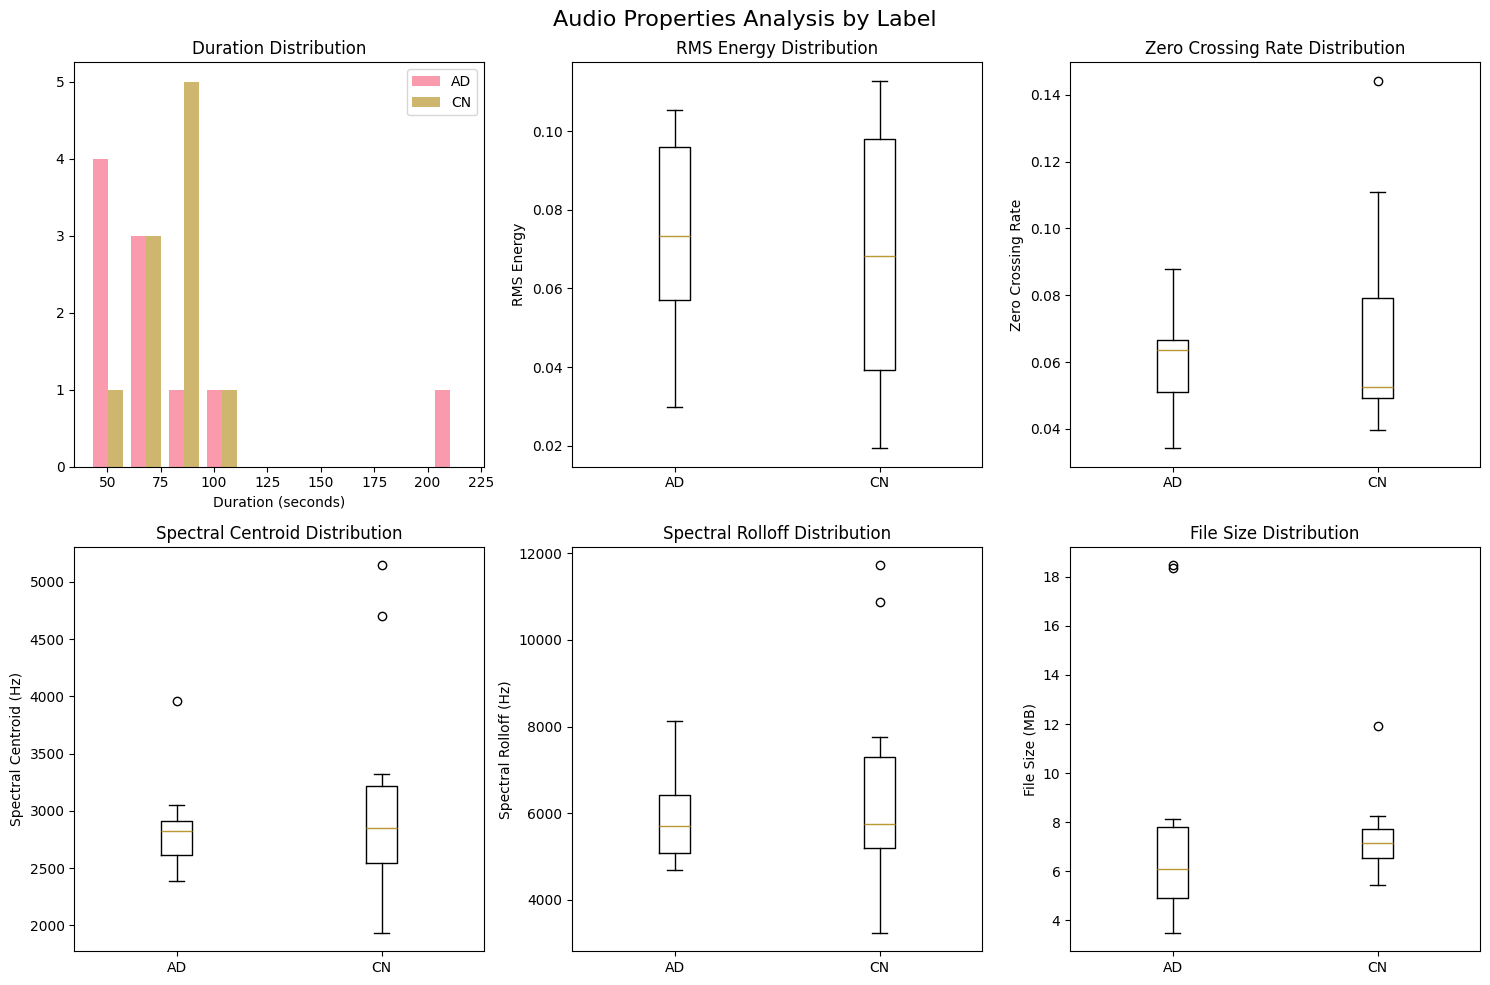


=== SEGMENTATION FILES ANALYSIS ===

Error processing adrso229.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso106.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso144.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso049.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso078.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso281.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso270.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso308.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso022.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso298.csv: unsupported operand type(s) for -: 'str' and 'str'

=== STATISTICAL ANALYSIS ===

Statistical Tests (AD vs CN):
------------------------------------------------------------
duration:
  T-test: 

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

class ADReSSoEDA:
    def __init__(self, base_path):
        self.base_path = base_path
        self.diagnosis_path = os.path.join(base_path, 'diagnosis')
        self.progression_path = os.path.join(base_path, 'progression')
        self.dataset_info = {}
        self.audio_features = {}

    def scan_dataset_structure(self):
        """Scan and analyze the dataset structure"""
        print("=== DATASET STRUCTURE ANALYSIS ===\n")

        structure = {}

        # Scan diagnosis folder
        if os.path.exists(self.diagnosis_path):
            structure['diagnosis'] = {}
            for subset in ['train', 'test-dist']:
                subset_path = os.path.join(self.diagnosis_path, subset)
                if os.path.exists(subset_path):
                    structure['diagnosis'][subset] = {}

                    # Count audio files
                    audio_path = os.path.join(subset_path, 'audio')
                    if os.path.exists(audio_path):
                        structure['diagnosis'][subset]['audio'] = {}
                        for label in ['ad', 'cn']:
                            label_path = os.path.join(audio_path, label)
                            if os.path.exists(label_path):
                                files = [f for f in os.listdir(label_path) if f.endswith('.wav')]
                                structure['diagnosis'][subset]['audio'][label] = len(files)

                    # Count segmentation files
                    seg_path = os.path.join(subset_path, 'segmentation')
                    if os.path.exists(seg_path):
                        structure['diagnosis'][subset]['segmentation'] = {}
                        for label in ['ad', 'cn']:
                            label_path = os.path.join(seg_path, label)
                            if os.path.exists(label_path):
                                files = [f for f in os.listdir(label_path) if f.endswith('.csv')]
                                structure['diagnosis'][subset]['segmentation'][label] = len(files)

        # Scan progression folder
        if os.path.exists(self.progression_path):
            structure['progression'] = {}
            for subset in ['test-dist']:
                subset_path = os.path.join(self.progression_path, subset)
                if os.path.exists(subset_path):
                    structure['progression'][subset] = {}

                    # Count audio files
                    audio_path = os.path.join(subset_path, 'audio')
                    if os.path.exists(audio_path):
                        files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
                        structure['progression'][subset]['audio'] = len(files)

                    # Count segmentation files
                    seg_path = os.path.join(subset_path, 'segmentation')
                    if os.path.exists(seg_path):
                        files = [f for f in os.listdir(seg_path) if f.endswith('.csv')]
                        structure['progression'][subset]['segmentation'] = len(files)

        self.dataset_info = structure
        self.print_structure()
        return structure

    def print_structure(self):
        """Print dataset structure in a readable format"""
        print("Dataset Structure:")
        for task, task_data in self.dataset_info.items():
            print(f"\n{task.upper()} TASK:")
            for subset, subset_data in task_data.items():
                print(f"  {subset}:")
                if 'audio' in subset_data:
                    if isinstance(subset_data['audio'], dict):
                        for label, count in subset_data['audio'].items():
                            print(f"    Audio files ({label}): {count}")
                    else:
                        print(f"    Audio files: {subset_data['audio']}")
                if 'segmentation' in subset_data:
                    if isinstance(subset_data['segmentation'], dict):
                        for label, count in subset_data['segmentation'].items():
                            print(f"    Segmentation files ({label}): {count}")
                    else:
                        print(f"    Segmentation files: {subset_data['segmentation']}")

    def analyze_audio_properties(self, sample_size=10):
        """Analyze basic audio properties"""
        print("\n=== AUDIO PROPERTIES ANALYSIS ===\n")

        audio_stats = []

        # Analyze diagnosis training data
        for label in ['ad', 'cn']:
            audio_dir = os.path.join(self.diagnosis_path, 'train', 'audio', label)
            if os.path.exists(audio_dir):
                wav_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

                # Sample files for analysis
                sample_files = wav_files[:sample_size] if len(wav_files) > sample_size else wav_files

                for file in sample_files:
                    filepath = os.path.join(audio_dir, file)
                    try:
                        # Load audio file
                        y, sr = librosa.load(filepath, sr=None)

                        # Calculate basic properties
                        duration = len(y) / sr
                        rms_energy = np.sqrt(np.mean(y**2))
                        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))

                        # Calculate spectral features
                        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

                        audio_stats.append({
                            'file': file,
                            'label': label,
                            'duration': duration,
                            'sample_rate': sr,
                            'rms_energy': rms_energy,
                            'zero_crossing_rate': zero_crossing_rate,
                            'spectral_centroid_mean': np.mean(spectral_centroids),
                            'spectral_rolloff_mean': np.mean(spectral_rolloff),
                            'file_size_mb': os.path.getsize(filepath) / (1024*1024)
                        })

                    except Exception as e:
                        print(f"Error processing {file}: {e}")

        self.audio_features = pd.DataFrame(audio_stats)

        if not self.audio_features.empty:
            # Print summary statistics
            print("Audio Properties Summary:")
            print(self.audio_features.groupby('label').agg({
                'duration': ['mean', 'std', 'min', 'max'],
                'sample_rate': ['mean', 'std'],
                'rms_energy': ['mean', 'std'],
                'zero_crossing_rate': ['mean', 'std'],
                'spectral_centroid_mean': ['mean', 'std'],
                'file_size_mb': ['mean', 'std']
            }).round(4))

            # Create visualizations
            self.plot_audio_properties()

        return self.audio_features

    def plot_audio_properties(self):
        """Create visualizations for audio properties"""
        if self.audio_features.empty:
            return

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Audio Properties Analysis by Label', fontsize=16)

        # Duration distribution
        axes[0, 0].hist([self.audio_features[self.audio_features['label'] == 'ad']['duration'],
                        self.audio_features[self.audio_features['label'] == 'cn']['duration']],
                       bins=10, alpha=0.7, label=['AD', 'CN'])
        axes[0, 0].set_title('Duration Distribution')
        axes[0, 0].set_xlabel('Duration (seconds)')
        axes[0, 0].legend()

        # RMS Energy
        axes[0, 1].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['rms_energy'],
                           self.audio_features[self.audio_features['label'] == 'cn']['rms_energy']],
                          labels=['AD', 'CN'])
        axes[0, 1].set_title('RMS Energy Distribution')
        axes[0, 1].set_ylabel('RMS Energy')

        # Zero Crossing Rate
        axes[0, 2].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['zero_crossing_rate'],
                           self.audio_features[self.audio_features['label'] == 'cn']['zero_crossing_rate']],
                          labels=['AD', 'CN'])
        axes[0, 2].set_title('Zero Crossing Rate Distribution')
        axes[0, 2].set_ylabel('Zero Crossing Rate')

        # Spectral Centroid
        axes[1, 0].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['spectral_centroid_mean'],
                           self.audio_features[self.audio_features['label'] == 'cn']['spectral_centroid_mean']],
                          labels=['AD', 'CN'])
        axes[1, 0].set_title('Spectral Centroid Distribution')
        axes[1, 0].set_ylabel('Spectral Centroid (Hz)')

        # Spectral Rolloff
        axes[1, 1].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['spectral_rolloff_mean'],
                           self.audio_features[self.audio_features['label'] == 'cn']['spectral_rolloff_mean']],
                          labels=['AD', 'CN'])
        axes[1, 1].set_title('Spectral Rolloff Distribution')
        axes[1, 1].set_ylabel('Spectral Rolloff (Hz)')

        # File Size
        axes[1, 2].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['file_size_mb'],
                           self.audio_features[self.audio_features['label'] == 'cn']['file_size_mb']],
                          labels=['AD', 'CN'])
        axes[1, 2].set_title('File Size Distribution')
        axes[1, 2].set_ylabel('File Size (MB)')

        plt.tight_layout()
        plt.show()

    def analyze_segmentation_files(self, sample_size=5):
        """Analyze segmentation CSV files"""
        print("\n=== SEGMENTATION FILES ANALYSIS ===\n")

        segmentation_stats = []

        for label in ['ad', 'cn']:
            seg_dir = os.path.join(self.diagnosis_path, 'train', 'segmentation', label)
            if os.path.exists(seg_dir):
                csv_files = [f for f in os.listdir(seg_dir) if f.endswith('.csv')]

                # Sample files for analysis
                sample_files = csv_files[:sample_size] if len(csv_files) > sample_size else csv_files

                for file in sample_files:
                    filepath = os.path.join(seg_dir, file)
                    try:
                        df = pd.read_csv(filepath)

                        # Basic stats about segmentation
                        segmentation_stats.append({
                            'file': file,
                            'label': label,
                            'num_segments': len(df),
                            'columns': list(df.columns),
                            'total_duration': df.iloc[:, 1].max() if len(df.columns) > 1 else 0,
                            'avg_segment_length': df.iloc[:, 1].diff().mean() if len(df.columns) > 1 else 0
                        })

                        # Print first few rows of first file as example
                        if file == sample_files[0]:
                            print(f"Sample segmentation file ({label}): {file}")
                            print(df.head())
                            print(f"Shape: {df.shape}")
                            print(f"Columns: {df.columns.tolist()}")
                            print("-" * 50)

                    except Exception as e:
                        print(f"Error processing {file}: {e}")

        if segmentation_stats:
            seg_df = pd.DataFrame(segmentation_stats)

            print("Segmentation Statistics:")
            print(seg_df.groupby('label').agg({
                'num_segments': ['mean', 'std', 'min', 'max'],
                'total_duration': ['mean', 'std'],
                'avg_segment_length': ['mean', 'std']
            }).round(4))

            # Plot segmentation statistics
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Number of segments
            axes[0].boxplot([seg_df[seg_df['label'] == 'ad']['num_segments'],
                            seg_df[seg_df['label'] == 'cn']['num_segments']],
                           labels=['AD', 'CN'])
            axes[0].set_title('Number of Segments per File')
            axes[0].set_ylabel('Number of Segments')

            # Average segment length
            axes[1].boxplot([seg_df[seg_df['label'] == 'ad']['avg_segment_length'],
                            seg_df[seg_df['label'] == 'cn']['avg_segment_length']],
                           labels=['AD', 'CN'])
            axes[1].set_title('Average Segment Length')
            axes[1].set_ylabel('Average Length (seconds)')

            plt.tight_layout()
            plt.show()

        return segmentation_stats

    def statistical_analysis(self):
        """Perform statistical analysis between AD and CN groups"""
        if self.audio_features.empty:
            return

        print("\n=== STATISTICAL ANALYSIS ===\n")

        ad_data = self.audio_features[self.audio_features['label'] == 'ad']
        cn_data = self.audio_features[self.audio_features['label'] == 'cn']

        features_to_test = ['duration', 'rms_energy', 'zero_crossing_rate',
                          'spectral_centroid_mean', 'spectral_rolloff_mean']

        print("Statistical Tests (AD vs CN):")
        print("-" * 60)

        for feature in features_to_test:
            if feature in ad_data.columns and feature in cn_data.columns:
                # T-test
                t_stat, p_value = stats.ttest_ind(ad_data[feature], cn_data[feature])

                # Mann-Whitney U test (non-parametric)
                u_stat, u_p_value = stats.mannwhitneyu(ad_data[feature], cn_data[feature])

                print(f"{feature}:")
                print(f"  T-test: t={t_stat:.4f}, p={p_value:.4f}")
                print(f"  Mann-Whitney U: U={u_stat:.4f}, p={u_p_value:.4f}")
                print(f"  AD mean: {ad_data[feature].mean():.4f} ± {ad_data[feature].std():.4f}")
                print(f"  CN mean: {cn_data[feature].mean():.4f} ± {cn_data[feature].std():.4f}")
                print()

    def run_complete_eda(self):
        """Run complete EDA analysis"""
        print("Starting Complete EDA for ADReSSo21 Dataset")
        print("=" * 50)

        # 1. Dataset structure analysis
        self.scan_dataset_structure()

        # 2. Audio properties analysis
        self.analyze_audio_properties()

        # 3. Segmentation analysis
        self.analyze_segmentation_files()

        # 4. Statistical analysis
        self.statistical_analysis()

        print("\n=== EDA COMPLETE ===")
        print("Summary of findings:")
        print(f"- Total diagnosis training files analyzed: {len(self.audio_features)}")
        print(f"- Labels: {self.audio_features['label'].value_counts().to_dict() if not self.audio_features.empty else 'None'}")

        return self.audio_features

# Usage example:
if __name__ == "__main__":
    # Initialize EDA
    dataset_path = "/content/drive/MyDrive/Voice/extracted/ADReSSo21"
    eda = ADReSSoEDA(dataset_path)

    # Run complete analysis
    results = eda.run_complete_eda()

    # Optional: Save results
    if not results.empty:
        results.to_csv("adresso_audio_features.csv", index=False)
        print(f"\nResults saved to: adresso_audio_features.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete! Libraries installed and paths configured.
Loading dataset...
Loaded 87 AD files, 79 CN files, 32 test files
Total files: 198

Dataset Overview:
       sample_rate    duration   num_samples
count        198.0  198.000000  1.980000e+02
mean       44100.0   89.020188  3.925790e+06
std            0.0   44.389815  1.957591e+06
min        44100.0   22.785261  1.004830e+06
25%        44100.0   56.959433  2.511911e+06
50%        44100.0   77.135544  3.401678e+06
75%        44100.0  114.715765  5.058965e+06
max        44100.0  268.486531  1.184026e+07
Performing time-domain analysis...


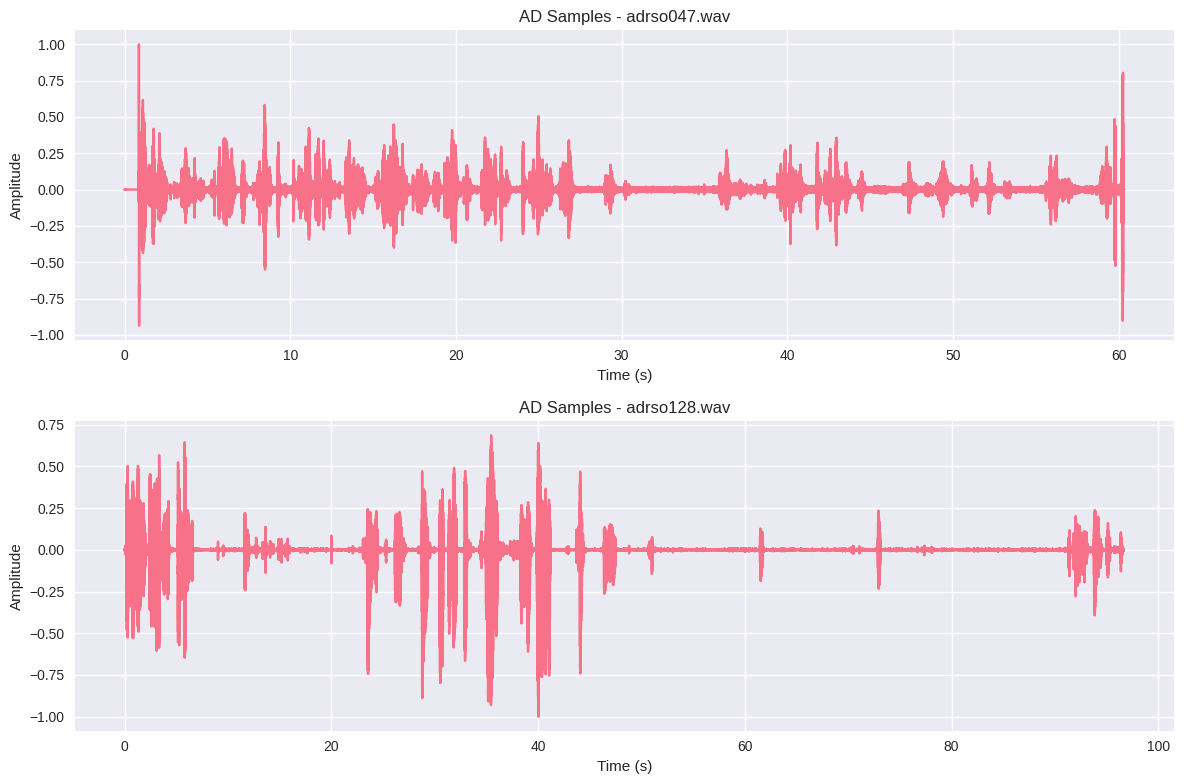

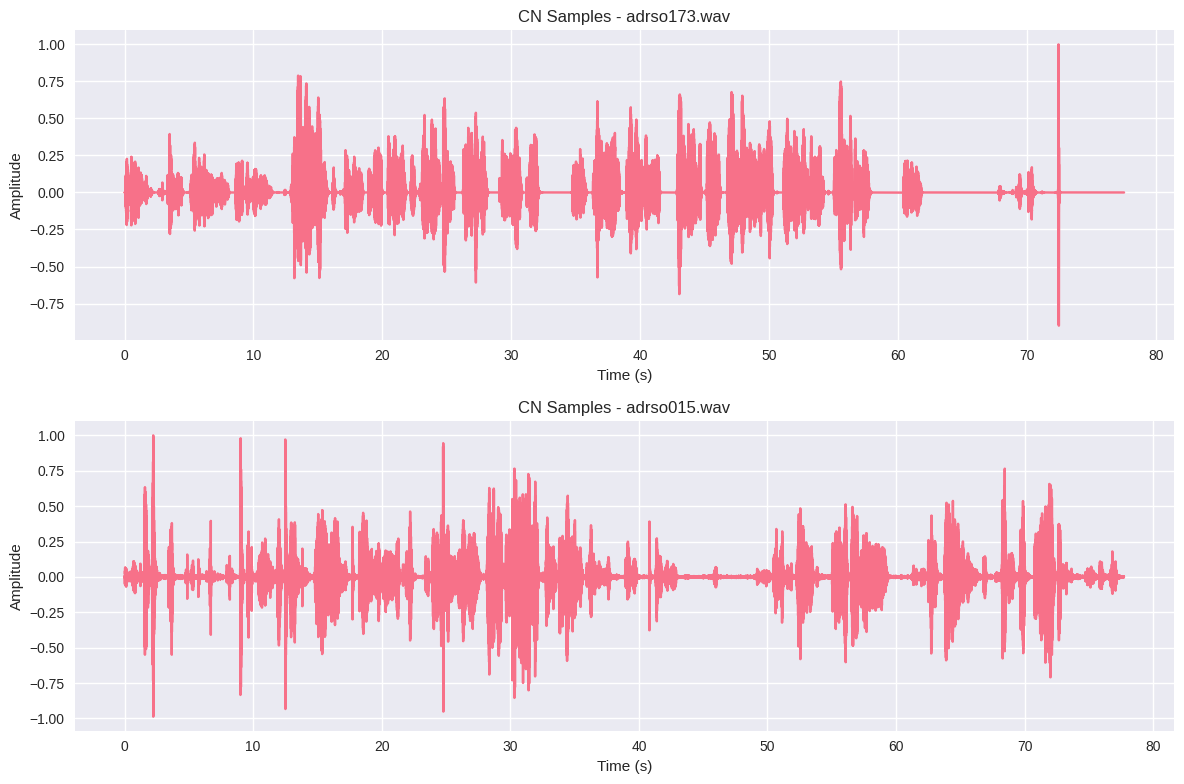


Amplitude Statistics:
      mean_amp                                                              \
         count      mean       std       min       25%       50%       75%   
label                                                                        
ad        87.0  0.025770  0.019399  0.003262  0.012885  0.022090  0.033035   
cn        79.0  0.034993  0.030636  0.004738  0.013070  0.028260  0.044795   
test      32.0  0.014117  0.011008  0.001795  0.008843  0.010504  0.013266   

                median_amp            ...   max_amp             rms            \
            max      count      mean  ...       75%       max count      mean   
label                                 ...                                       
ad     0.119391       87.0  0.004239  ...  0.999969  1.018751  87.0  0.059942   
cn     0.155745       79.0  0.008456  ...  0.999969  1.819208  79.0  0.073331   
test   0.055864       32.0  0.001440  ...  0.927078  1.017102  32.0  0.042639   

                     

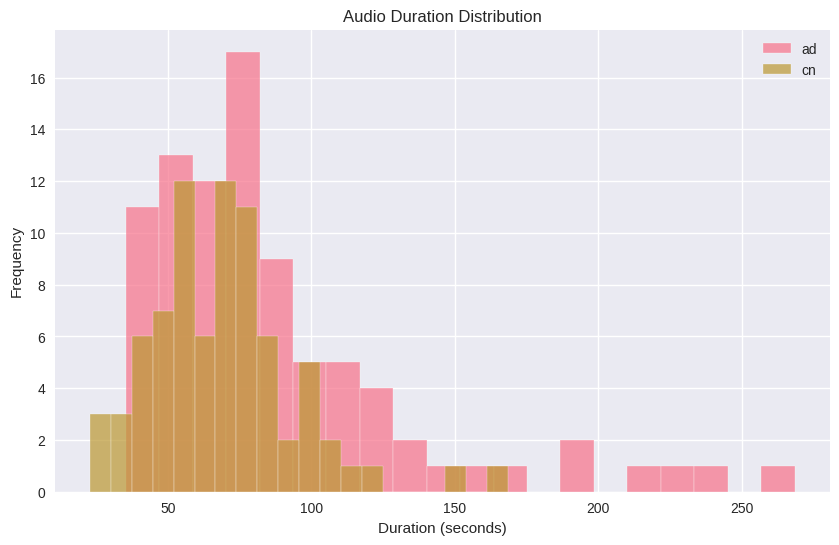


Silence Detection Results:
      silence_ratio                                                   \
              count      mean           std  min       25%       50%   
label                                                                  
ad             87.0  0.185782  2.623039e-02  0.0  0.181229  0.195982   
cn             79.0  0.182392  3.496076e-02  0.0  0.183039  0.196424   
test           32.0  0.200000  5.689965e-08  0.2  0.200000  0.200000   

                     threshold                                          \
            75%  max     count      mean       std       min       25%   
label                                                                    
ad     0.199438  0.2      87.0  0.000790  0.001112  0.000000  0.000137   
cn     0.199296  0.2      79.0  0.001203  0.001632  0.000000  0.000183   
test   0.200000  0.2      32.0  0.000492  0.000253  0.000158  0.000295   

                                     
            50%       75%       max  
label             

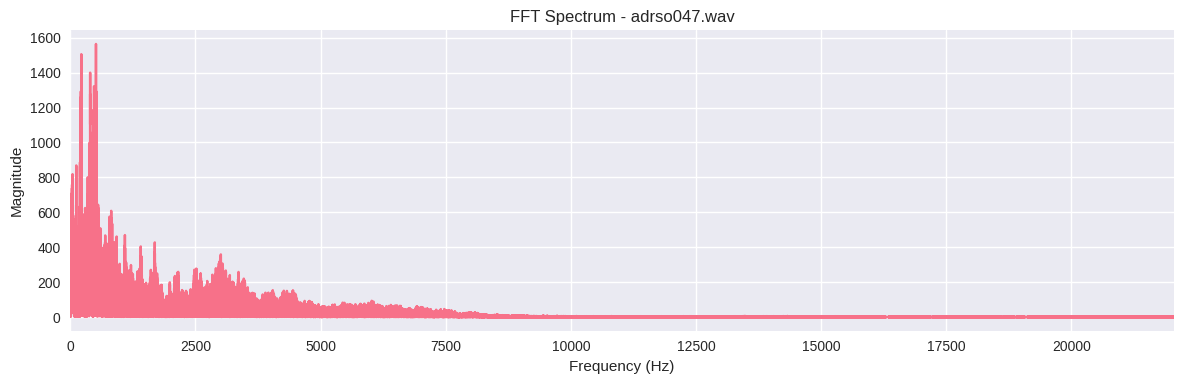

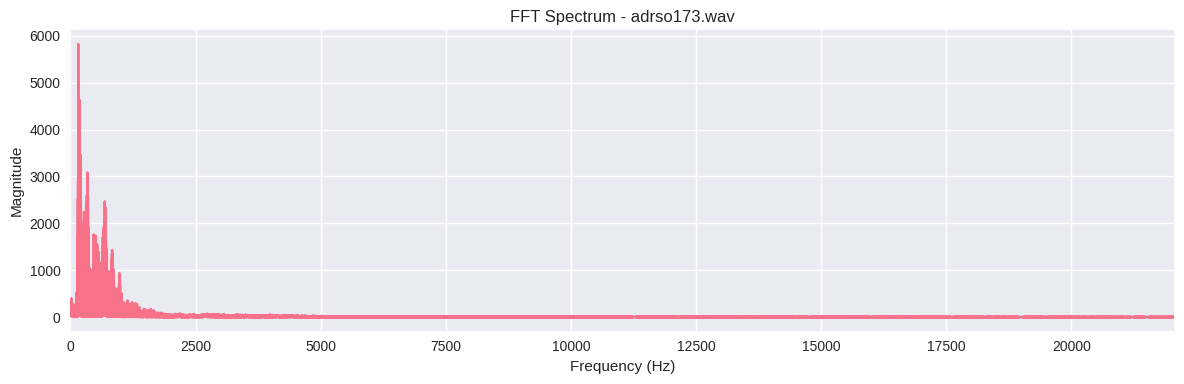


Spectral Features:
      spectral_centroid_mean                                        \
                       count         mean         std          min   
label                                                                
ad                      87.0  3116.474925  929.535563   929.267704   
cn                      79.0  3127.916676  921.092234  1799.468640   
test                    32.0  2642.960751  825.937013  1312.231883   

                                                           \
               25%          50%          75%          max   
label                                                       
ad     2524.282091  2938.678943  3742.915112  5378.281834   
cn     2496.582175  2919.695882  3442.058056  5624.673360   
test   2009.919038  2511.326888  3419.951200  4162.480351   

      spectral_centroid_std               ... spectral_bandwidth_mean  \
                      count         mean  ...                     75%   
label                                     ... 

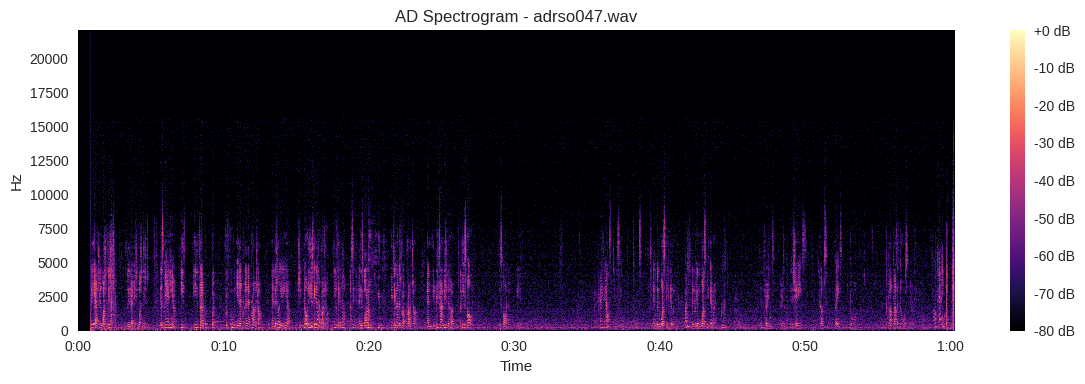

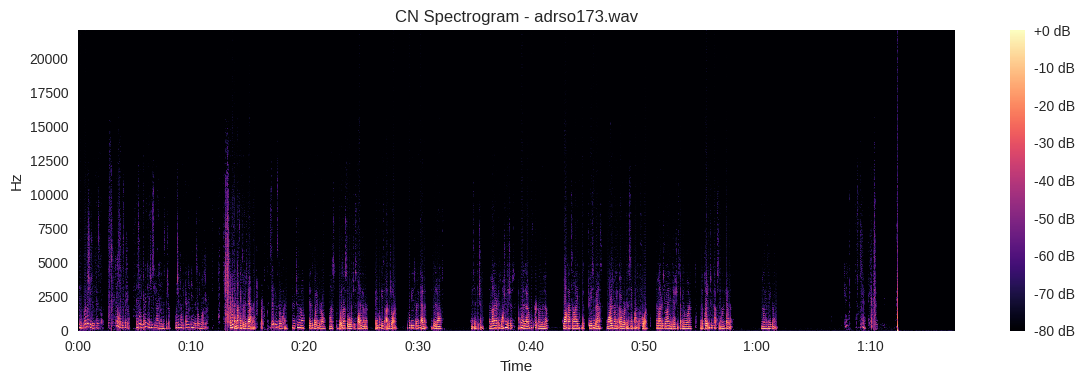

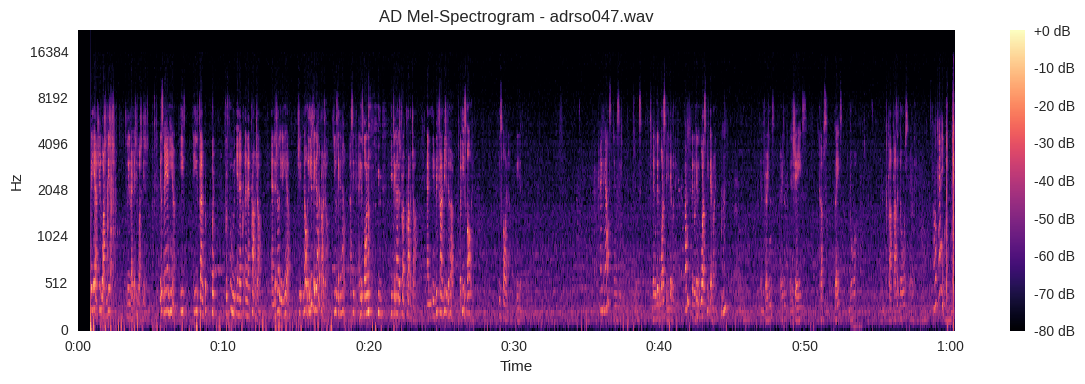

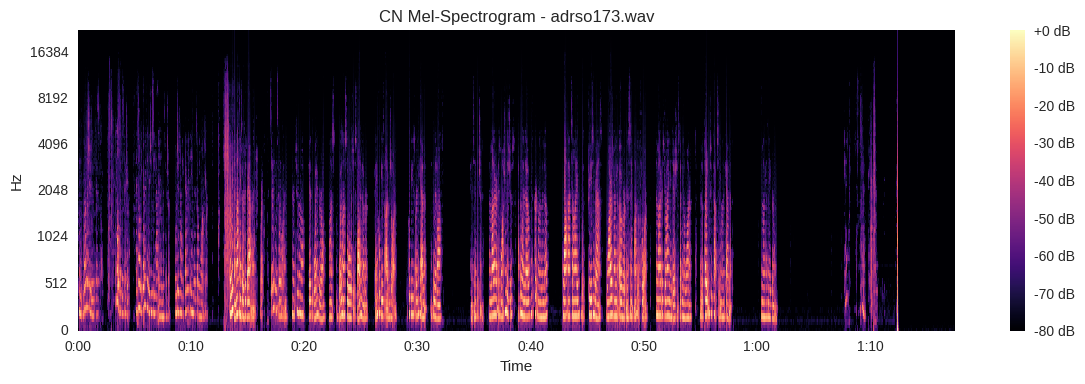

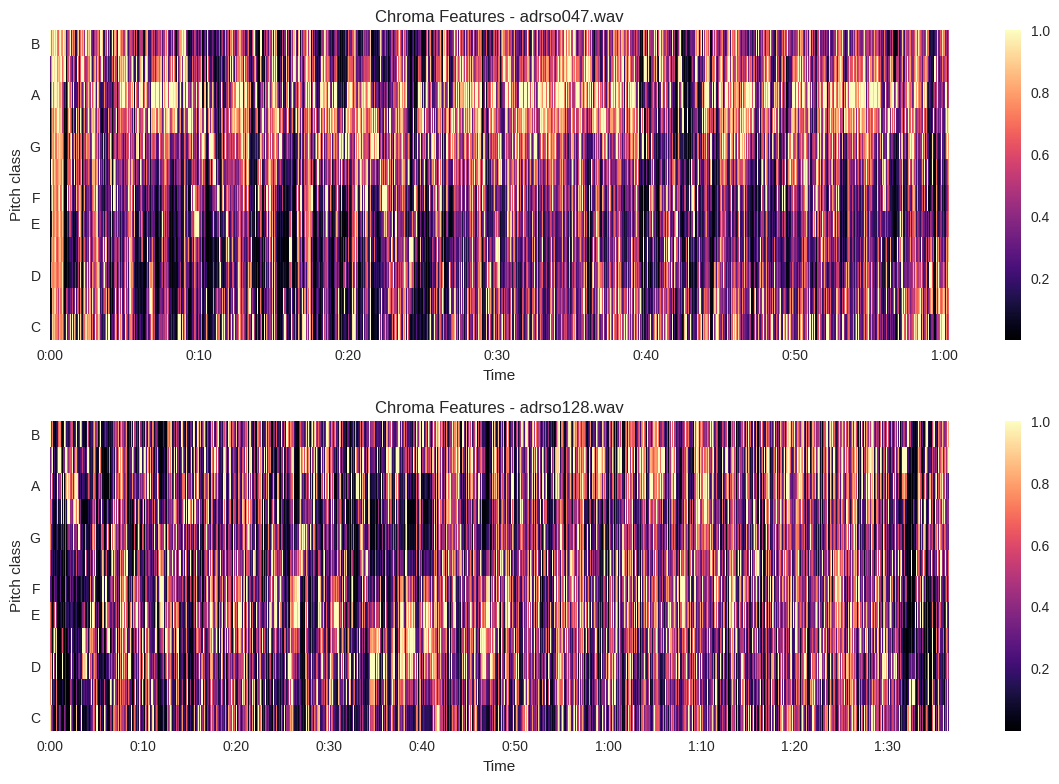

Extracting statistical and feature-based analysis...

MFCC Features extracted
Delta and Delta-Delta features extracted
Energy features extracted

Combined features shape: (198, 99)


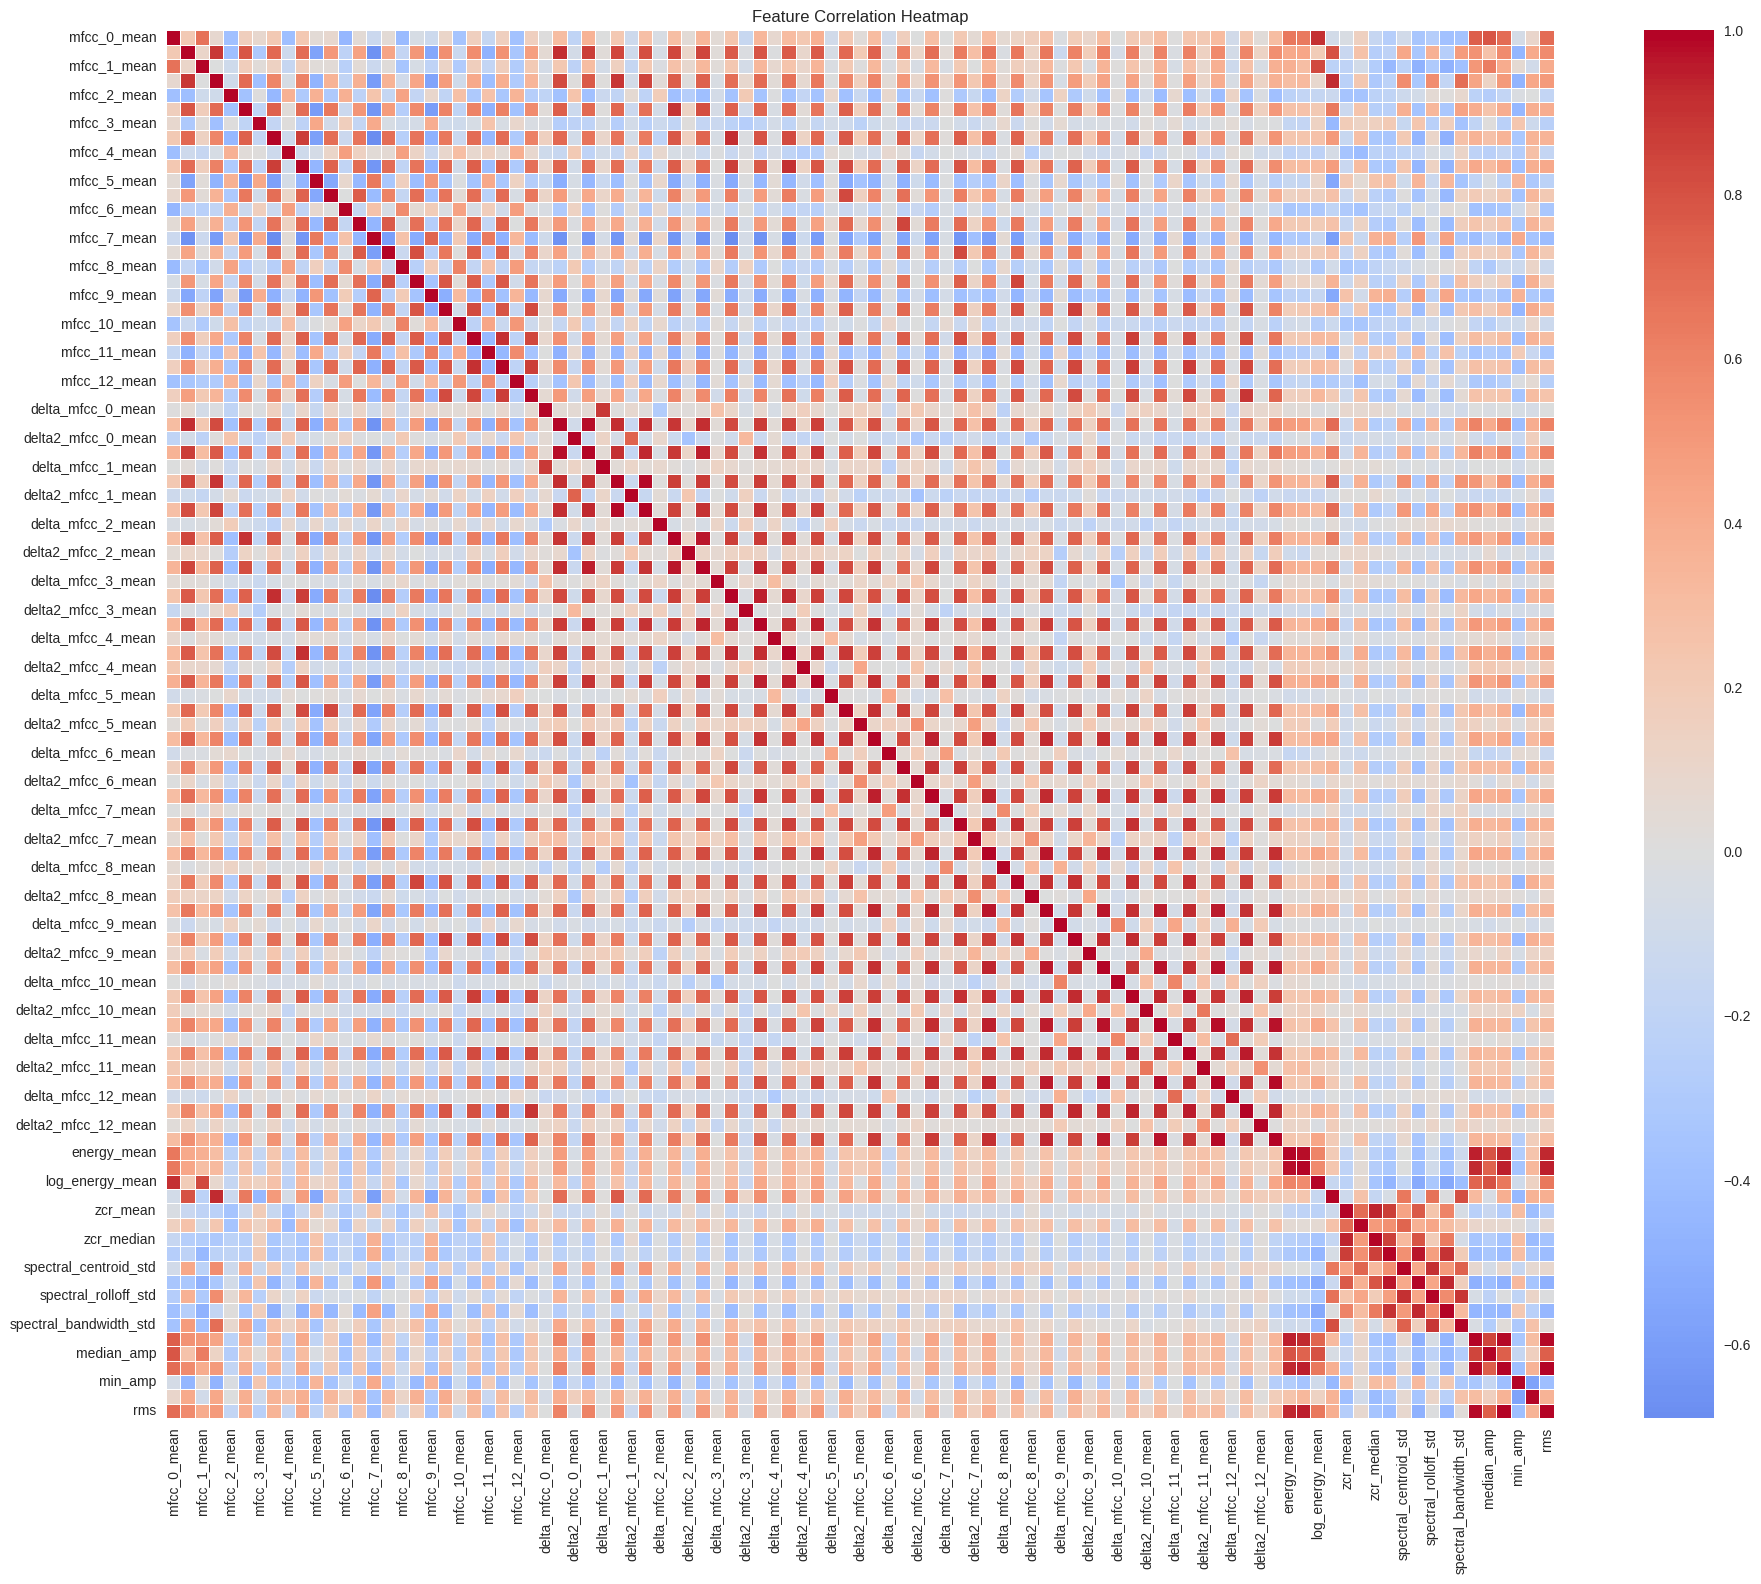

Performing dataset-level analysis...


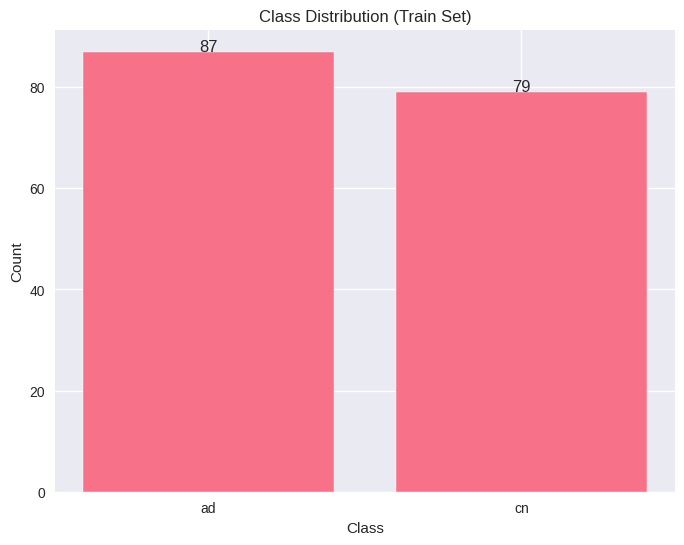


Sample Rate Analysis:
sample_rate
44100    198
Name: count, dtype: int64

File Integrity Check:
Files with zero duration: 0
Files with very short duration (<1s): 0
Files with very long duration (>300s): 0


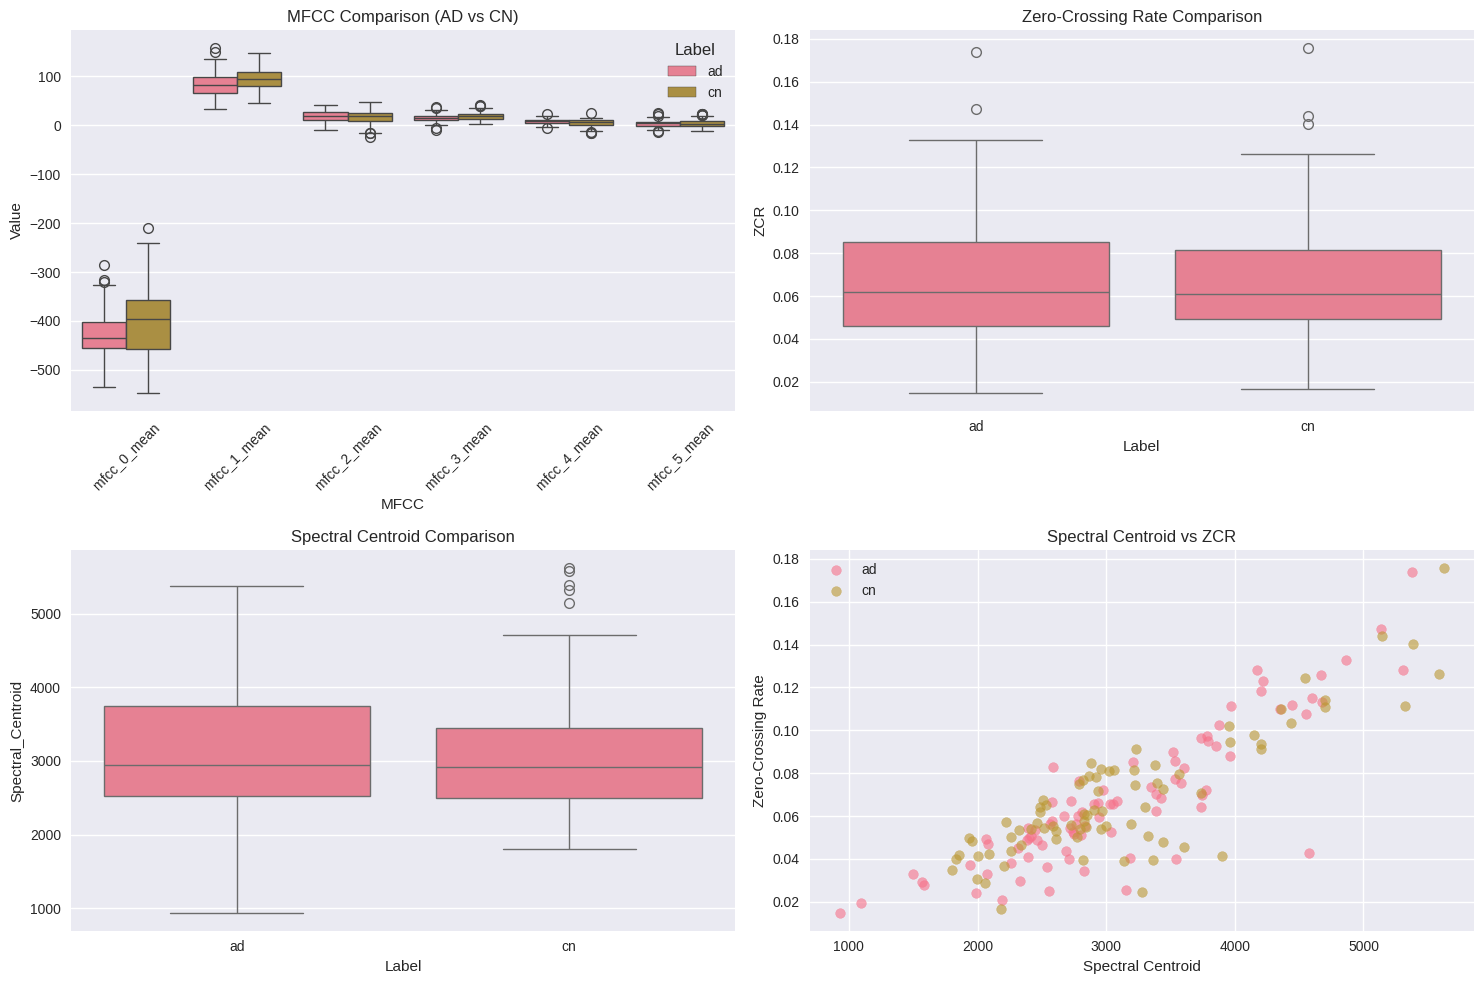

Performing anomaly detection...

Outlier detection completed. Found outliers in 97 features.

SNR Statistics:
       count       mean       std        min        25%        50%        75%  \
label                                                                           
ad      87.0        inf       NaN  30.375994  42.364645  57.177448        NaN   
cn      79.0        inf       NaN  25.869949  45.354536  57.428825  75.104141   
test    32.0  49.364183  5.640773  37.550476  45.462119  49.750238  52.459129   

             max  
label             
ad           inf  
cn           inf  
test   62.985085  


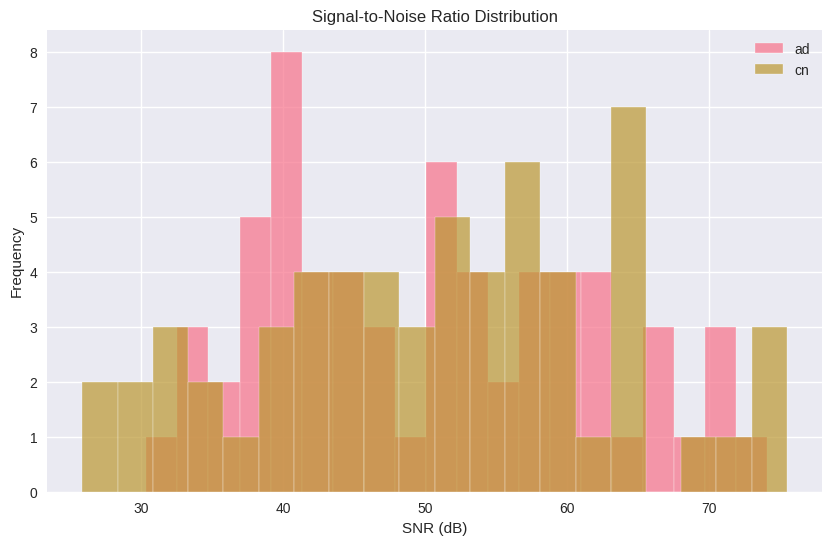

In [23]:
# ADReSSo21 Audio Data Analysis Workflow for Google Colab
# Alzheimer's Dementia Recognition through Speech (ADReSSo21 Dataset)

# ================================
# 1. INITIAL SETUP
# ================================

# Install required libraries
!pip install librosa soundfile scikit-learn imbalanced-learn

# Import libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from scipy import signal, stats
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
BASE_PATH = '/content/drive/MyDrive/Voice/extracted/ADReSSo21'
AUDIO_PATHS = {
    'train_ad': f'{BASE_PATH}/diagnosis/train/audio/ad/*.wav',
    'train_cn': f'{BASE_PATH}/diagnosis/train/audio/cn/*.wav',
    'test': f'{BASE_PATH}/progression/test-dist/audio/*.wav'
}

SEGMENTATION_PATHS = {
    'train_ad': f'{BASE_PATH}/diagnosis/train/segmentation/ad/*.csv',
    'train_cn': f'{BASE_PATH}/diagnosis/train/segmentation/cn/*.csv',
    'test': f'{BASE_PATH}/progression/test-dist/segmentation/*.csv'
}

# Create output directories
os.makedirs('/content/output/visualizations', exist_ok=True)
os.makedirs('/content/output/preprocessed', exist_ok=True)
os.makedirs('/content/output/features', exist_ok=True)

print("Setup complete! Libraries installed and paths configured.")

# ================================
# UTILITY FUNCTIONS
# ================================

def load_audio_files(pattern, label=None):
    """Load audio files matching a pattern."""
    files = glob.glob(pattern)
    audio_data = []

    for file_path in files:
        try:
            y, sr = librosa.load(file_path, sr=None)
            audio_data.append({
                'file_path': file_path,
                'filename': os.path.basename(file_path),
                'audio': y,
                'sample_rate': sr,
                'label': label,
                'duration': len(y) / sr
            })
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return audio_data

def load_segmentation_files(pattern):
    """Load segmentation CSV files."""
    files = glob.glob(pattern)
    segmentation_data = {}

    for file_path in files:
        try:
            df = pd.read_csv(file_path)
            filename = os.path.basename(file_path).replace('.csv', '.wav')
            segmentation_data[filename] = df
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return segmentation_data

def create_metadata_dataframe(audio_data):
    """Create metadata DataFrame from audio data."""
    metadata = []
    for item in audio_data:
        metadata.append({
            'filename': item['filename'],
            'file_path': item['file_path'],
            'label': item['label'],
            'sample_rate': item['sample_rate'],
            'duration': item['duration'],
            'num_samples': len(item['audio'])
        })

    return pd.DataFrame(metadata)

# ================================
# 2. INITIAL EDA
# ================================

print("Loading dataset...")

# Load audio files
train_ad_data = load_audio_files(AUDIO_PATHS['train_ad'], 'ad')
train_cn_data = load_audio_files(AUDIO_PATHS['train_cn'], 'cn')
test_data = load_audio_files(AUDIO_PATHS['test'], 'test')

# Load segmentation files
train_ad_seg = load_segmentation_files(SEGMENTATION_PATHS['train_ad'])
train_cn_seg = load_segmentation_files(SEGMENTATION_PATHS['train_cn'])
test_seg = load_segmentation_files(SEGMENTATION_PATHS['test'])

# Combine all data
all_audio_data = train_ad_data + train_cn_data + test_data

# Create metadata DataFrame
metadata_df = create_metadata_dataframe(all_audio_data)

print(f"Loaded {len(train_ad_data)} AD files, {len(train_cn_data)} CN files, {len(test_data)} test files")
print(f"Total files: {len(all_audio_data)}")

# Display basic statistics
print("\nDataset Overview:")
print(metadata_df.describe())

# ================================
# TIME-DOMAIN ANALYSIS
# ================================

def plot_waveforms(audio_data, title_prefix="", max_plots=3):
    """Plot waveforms for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    for i, item in enumerate(audio_data[:max_plots]):
        time = np.linspace(0, item['duration'], len(item['audio']))
        axes[i].plot(time, item['audio'])
        axes[i].set_title(f"{title_prefix} - {item['filename']}")
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig(f'/content/output/visualizations/waveforms_{title_prefix.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()

def compute_amplitude_statistics(audio_data):
    """Compute amplitude statistics for audio files."""
    stats_data = []

    for item in audio_data:
        y = item['audio']
        stats_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'mean_amp': np.mean(np.abs(y)),
            'median_amp': np.median(np.abs(y)),
            'std_amp': np.std(y),
            'min_amp': np.min(y),
            'max_amp': np.max(y),
            'rms': np.sqrt(np.mean(y**2))
        })

    return pd.DataFrame(stats_data)

def compute_zero_crossing_rate(audio_data):
    """Compute zero-crossing rate for audio files."""
    zcr_data = []

    for item in audio_data:
        zcr = librosa.feature.zero_crossing_rate(item['audio'])[0]
        zcr_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'zcr_mean': np.mean(zcr),
            'zcr_std': np.std(zcr),
            'zcr_median': np.median(zcr)
        })

    return pd.DataFrame(zcr_data)

def detect_silence(audio_data, threshold_percentile=20):
    """Detect silence periods in audio files."""
    silence_data = []

    for item in audio_data:
        y = item['audio']
        threshold = np.percentile(np.abs(y), threshold_percentile)
        silence_mask = np.abs(y) < threshold
        silence_ratio = np.sum(silence_mask) / len(y)

        silence_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'silence_ratio': silence_ratio,
            'threshold': threshold
        })

    return pd.DataFrame(silence_data)

print("Performing time-domain analysis...")

# Plot sample waveforms
plot_waveforms(train_ad_data, "AD Samples", max_plots=2)
plot_waveforms(train_cn_data, "CN Samples", max_plots=2)

# Compute amplitude statistics
amp_stats = compute_amplitude_statistics(all_audio_data)
print("\nAmplitude Statistics:")
print(amp_stats.groupby('label').describe())

# Compute zero-crossing rate
zcr_stats = compute_zero_crossing_rate(all_audio_data)
print("\nZero-Crossing Rate Statistics:")
print(zcr_stats.groupby('label').describe())

# Plot duration histogram
plt.figure(figsize=(10, 6))
for label in ['ad', 'cn']:
    durations = metadata_df[metadata_df['label'] == label]['duration']
    plt.hist(durations, alpha=0.7, label=label, bins=20)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Audio Duration Distribution')
plt.legend()
plt.grid(True)
plt.savefig('/content/output/visualizations/duration_histogram.png', dpi=150)
plt.show()

# Detect silence
silence_stats = detect_silence(all_audio_data)
print("\nSilence Detection Results:")
print(silence_stats.groupby('label').describe())

# ================================
# FREQUENCY-DOMAIN ANALYSIS
# ================================

def compute_fft_spectrum(audio_data, max_plots=2):
    """Compute and plot FFT spectrum for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    for i, item in enumerate(audio_data[:max_plots]):
        y = item['audio']
        sr = item['sample_rate']

        # Compute FFT
        n = len(y)
        yf = fft(y)
        xf = fftfreq(n, 1/sr)

        # Plot only positive frequencies
        pos_mask = xf >= 0
        axes[i].plot(xf[pos_mask], np.abs(yf[pos_mask]))
        axes[i].set_title(f"FFT Spectrum - {item['filename']}")
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylabel('Magnitude')
        axes[i].set_xlim(0, sr/2)
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/fft_spectrum.png', dpi=150)
    plt.show()

def compute_spectral_features(audio_data):
    """Compute spectral features for audio files."""
    spectral_data = []

    for item in audio_data:
        y = item['audio']
        sr = item['sample_rate']

        # Compute spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

        spectral_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'spectral_centroid_mean': np.mean(spectral_centroids),
            'spectral_centroid_std': np.std(spectral_centroids),
            'spectral_rolloff_mean': np.mean(spectral_rolloff),
            'spectral_rolloff_std': np.std(spectral_rolloff),
            'spectral_bandwidth_mean': np.mean(spectral_bandwidth),
            'spectral_bandwidth_std': np.std(spectral_bandwidth)
        })

    return pd.DataFrame(spectral_data)

print("Performing frequency-domain analysis...")

# Compute FFT spectrum for samples
compute_fft_spectrum(train_ad_data, max_plots=1)
compute_fft_spectrum(train_cn_data, max_plots=1)

# Compute spectral features
spectral_features = compute_spectral_features(all_audio_data)
print("\nSpectral Features:")
print(spectral_features.groupby('label').describe())

# ================================
# TIME-FREQUENCY ANALYSIS
# ================================

def plot_spectrograms(audio_data, title_prefix="", max_plots=2):
    """Generate and plot spectrograms for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    for i, item in enumerate(audio_data[:max_plots]):
        y = item['audio']
        sr = item['sample_rate']

        # Compute spectrogram
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[i])
        axes[i].set_title(f"{title_prefix} Spectrogram - {item['filename']}")
        fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig(f'/content/output/visualizations/spectrograms_{title_prefix.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()

def plot_mel_spectrograms(audio_data, title_prefix="", max_plots=2):
    """Generate and plot Mel-spectrograms for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    for i, item in enumerate(audio_data[:max_plots]):
        y = item['audio']
        sr = item['sample_rate']

        # Compute Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[i])
        axes[i].set_title(f"{title_prefix} Mel-Spectrogram - {item['filename']}")
        fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig(f'/content/output/visualizations/mel_spectrograms_{title_prefix.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()

def extract_chroma_features(audio_data, max_plots=2):
    """Extract and plot chroma features for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    chroma_data = []

    for i, item in enumerate(audio_data[:max_plots]):
        y = item['audio']
        sr = item['sample_rate']

        # Compute chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        # Plot chroma features
        img = librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', ax=axes[i])
        axes[i].set_title(f"Chroma Features - {item['filename']}")
        fig.colorbar(img, ax=axes[i])

        # Store chroma statistics
        chroma_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'chroma_mean': np.mean(chroma),
            'chroma_std': np.std(chroma)
        })

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/chroma_features.png', dpi=150)
    plt.show()

    return pd.DataFrame(chroma_data)

print("Performing time-frequency analysis...")

# Generate spectrograms
plot_spectrograms(train_ad_data, "AD", max_plots=1)
plot_spectrograms(train_cn_data, "CN", max_plots=1)

# Generate Mel-spectrograms
plot_mel_spectrograms(train_ad_data, "AD", max_plots=1)
plot_mel_spectrograms(train_cn_data, "CN", max_plots=1)

# Extract chroma features
chroma_features = extract_chroma_features(train_ad_data + train_cn_data, max_plots=2)

# ================================
# STATISTICAL AND FEATURE-BASED ANALYSIS
# ================================

def extract_mfcc_features(audio_data, n_mfcc=13):
    """Extract MFCC features for audio files."""
    mfcc_data = []

    for item in audio_data:
        y = item['audio']
        sr = item['sample_rate']

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Compute statistics for each MFCC coefficient
        mfcc_stats = {}
        for i in range(n_mfcc):
            mfcc_stats[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
            mfcc_stats[f'mfcc_{i}_std'] = np.std(mfccs[i])

        mfcc_stats['filename'] = item['filename']
        mfcc_stats['label'] = item['label']
        mfcc_data.append(mfcc_stats)

    return pd.DataFrame(mfcc_data)

def extract_delta_features(audio_data, n_mfcc=13):
    """Extract delta and delta-delta features for MFCCs."""
    delta_data = []

    for item in audio_data:
        y = item['audio']
        sr = item['sample_rate']

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Compute delta and delta-delta
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        # Compute statistics
        delta_stats = {}
        for i in range(n_mfcc):
            delta_stats[f'delta_mfcc_{i}_mean'] = np.mean(delta_mfccs[i])
            delta_stats[f'delta_mfcc_{i}_std'] = np.std(delta_mfccs[i])
            delta_stats[f'delta2_mfcc_{i}_mean'] = np.mean(delta2_mfccs[i])
            delta_stats[f'delta2_mfcc_{i}_std'] = np.std(delta2_mfccs[i])

        delta_stats['filename'] = item['filename']
        delta_stats['label'] = item['label']
        delta_data.append(delta_stats)

    return pd.DataFrame(delta_data)

def compute_energy_features(audio_data):
    """Compute short-term energy and log-energy features."""
    energy_data = []

    for item in audio_data:
        y = item['audio']

        # Compute short-term energy
        frame_length = 2048
        hop_length = 512

        # Frame the signal
        frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)

        # Compute energy for each frame
        energy = np.sum(frames**2, axis=0)
        log_energy = np.log(energy + 1e-8)  # Add small epsilon to avoid log(0)

        energy_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'energy_mean': np.mean(energy),
            'energy_std': np.std(energy),
            'log_energy_mean': np.mean(log_energy),
            'log_energy_std': np.std(log_energy)
        })

    return pd.DataFrame(energy_data)

print("Extracting statistical and feature-based analysis...")

# Extract MFCC features
mfcc_features = extract_mfcc_features(all_audio_data)
print("\nMFCC Features extracted")

# Extract delta features
delta_features = extract_delta_features(all_audio_data)
print("Delta and Delta-Delta features extracted")

# Compute energy features
energy_features = compute_energy_features(all_audio_data)
print("Energy features extracted")

# Combine all features
all_features = pd.merge(mfcc_features, delta_features, on=['filename', 'label'])
all_features = pd.merge(all_features, energy_features, on=['filename', 'label'])
all_features = pd.merge(all_features, zcr_stats, on=['filename', 'label'])
all_features = pd.merge(all_features, spectral_features, on=['filename', 'label'])
all_features = pd.merge(all_features, amp_stats, on=['filename', 'label'])

print(f"\nCombined features shape: {all_features.shape}")

# Create correlation heatmap
plt.figure(figsize=(20, 16))
# Select only numeric columns for correlation
numeric_cols = all_features.select_dtypes(include=[np.number]).columns
corr_matrix = all_features[numeric_cols].corr()

# Plot heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('/content/output/visualizations/feature_correlation_heatmap.png', dpi=150)
plt.show()

# ================================
# DATASET-LEVEL ANALYSIS
# ================================

print("Performing dataset-level analysis...")

# Plot class distribution
train_data = all_features[all_features['label'].isin(['ad', 'cn'])]
plt.figure(figsize=(8, 6))
class_counts = train_data['label'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution (Train Set)')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center')
plt.savefig('/content/output/visualizations/class_distribution.png', dpi=150)
plt.show()

# Check sample rate consistency
print("\nSample Rate Analysis:")
print(metadata_df['sample_rate'].value_counts())

# Check for corrupted files
print("\nFile Integrity Check:")
print(f"Files with zero duration: {sum(metadata_df['duration'] == 0)}")
print(f"Files with very short duration (<1s): {sum(metadata_df['duration'] < 1)}")
print(f"Files with very long duration (>300s): {sum(metadata_df['duration'] > 300)}")

# ================================
# VISUALIZATION TECHNIQUES
# ================================

def create_comparison_plots():
    """Create comparison plots for AD vs CN."""

    # MFCC comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # MFCC boxplot
    mfcc_cols = [col for col in all_features.columns if 'mfcc_' in col and '_mean' in col][:6]
    mfcc_data = []
    for col in mfcc_cols:
        for label in ['ad', 'cn']:
            values = all_features[all_features['label'] == label][col]
            for val in values:
                mfcc_data.append({'MFCC': col, 'Value': val, 'Label': label})

    mfcc_df = pd.DataFrame(mfcc_data)
    sns.boxplot(data=mfcc_df, x='MFCC', y='Value', hue='Label', ax=axes[0,0])
    axes[0,0].set_title('MFCC Comparison (AD vs CN)')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

    # ZCR comparison
    zcr_data = []
    for label in ['ad', 'cn']:
        values = all_features[all_features['label'] == label]['zcr_mean']
        for val in values:
            zcr_data.append({'ZCR': val, 'Label': label})

    zcr_df = pd.DataFrame(zcr_data)
    sns.boxplot(data=zcr_df, x='Label', y='ZCR', ax=axes[0,1])
    axes[0,1].set_title('Zero-Crossing Rate Comparison')

    # Spectral centroid comparison
    spec_data = []
    for label in ['ad', 'cn']:
        values = all_features[all_features['label'] == label]['spectral_centroid_mean']
        for val in values:
            spec_data.append({'Spectral_Centroid': val, 'Label': label})

    spec_df = pd.DataFrame(spec_data)
    sns.boxplot(data=spec_df, x='Label', y='Spectral_Centroid', ax=axes[1,0])
    axes[1,0].set_title('Spectral Centroid Comparison')

    # Scatter plot: Spectral centroid vs ZCR
    for label in ['ad', 'cn']:
        data = all_features[all_features['label'] == label]
        axes[1,1].scatter(data['spectral_centroid_mean'], data['zcr_mean'],
                         alpha=0.6, label=label)

    axes[1,1].set_xlabel('Spectral Centroid')
    axes[1,1].set_ylabel('Zero-Crossing Rate')
    axes[1,1].set_title('Spectral Centroid vs ZCR')
    axes[1,1].legend()
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/feature_comparison_plots.png', dpi=150)
    plt.show()

create_comparison_plots()

# ================================
# ANOMALY DETECTION
# ================================

def detect_outliers(features_df, z_threshold=3):
    """Detect outliers using z-scores."""
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    outlier_info = {}

    for col in numeric_cols:
        z_scores = np.abs(stats.zscore(features_df[col].fillna(0)))
        outliers = features_df[z_scores > z_threshold]
        outlier_info[col] = {
            'count': len(outliers),
            'filenames': outliers['filename'].tolist()
        }

    return outlier_info

def compute_snr(audio_data):
    """Compute signal-to-noise ratio for audio files."""
    snr_data = []

    for item in audio_data:
        y = item['audio']

        # Simple SNR estimation (signal power / noise power)
        # Assume noise is the quietest 10% of the signal
        signal_power = np.mean(y**2)
        noise_threshold = np.percentile(np.abs(y), 10)
        noise_power = np.mean(y[np.abs(y) < noise_threshold]**2)

        if noise_power > 0:
            snr = 10 * np.log10(signal_power / noise_power)
        else:
            snr = np.inf

        snr_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'snr': snr
        })

    return pd.DataFrame(snr_data)

print("Performing anomaly detection...")

# Detect outliers
outlier_info = detect_outliers(all_features)
print(f"\nOutlier detection completed. Found outliers in {len(outlier_info)} features.")

# Compute SNR
snr_data = compute_snr(all_audio_data)
print("\nSNR Statistics:")
print(snr_data.groupby('label')['snr'].describe())

# Plot SNR distribution
plt.figure(figsize=(10, 6))
for label in ['ad', 'cn']:
    snr_values = snr_data[snr_data['label'] == label]['snr']
    # Remove infinite values for plotting
    snr_values = snr_values[snr_values != np.inf]
    plt.hist(snr_values, alpha=0.7, label=label, bins=20)

plt.xlabel('SNR (dB)')
plt.ylabel('Frequency')
plt.title('Signal-to-Noise Ratio Distribution')
plt.legend()
plt.grid(True)
plt.savefig('/content/output/visualizations/snr_distribution.png', dpi=150)
plt.show()

Starting light preprocessing...
1. Resampling audio to 16 kHz...
2. Converting to mono...
3. Normalizing amplitude...
4. Removing corrupted files...
Removed 0 corrupted files: []
5. Trimming silence...
6. Aligning with segmentation data...
Light preprocessing complete. 198 files processed.
Preprocessed dataset shape: (198, 6)
Average duration after preprocessing: 88.88 seconds
Starting deeper EDA on preprocessed data...
Recomputing MFCCs...
Recomputing delta features...
Recomputing ZCR...
Recomputing spectral features...
Recomputing energy features...
Recomputing amplitude statistics...
Preprocessed features shape: (198, 99)


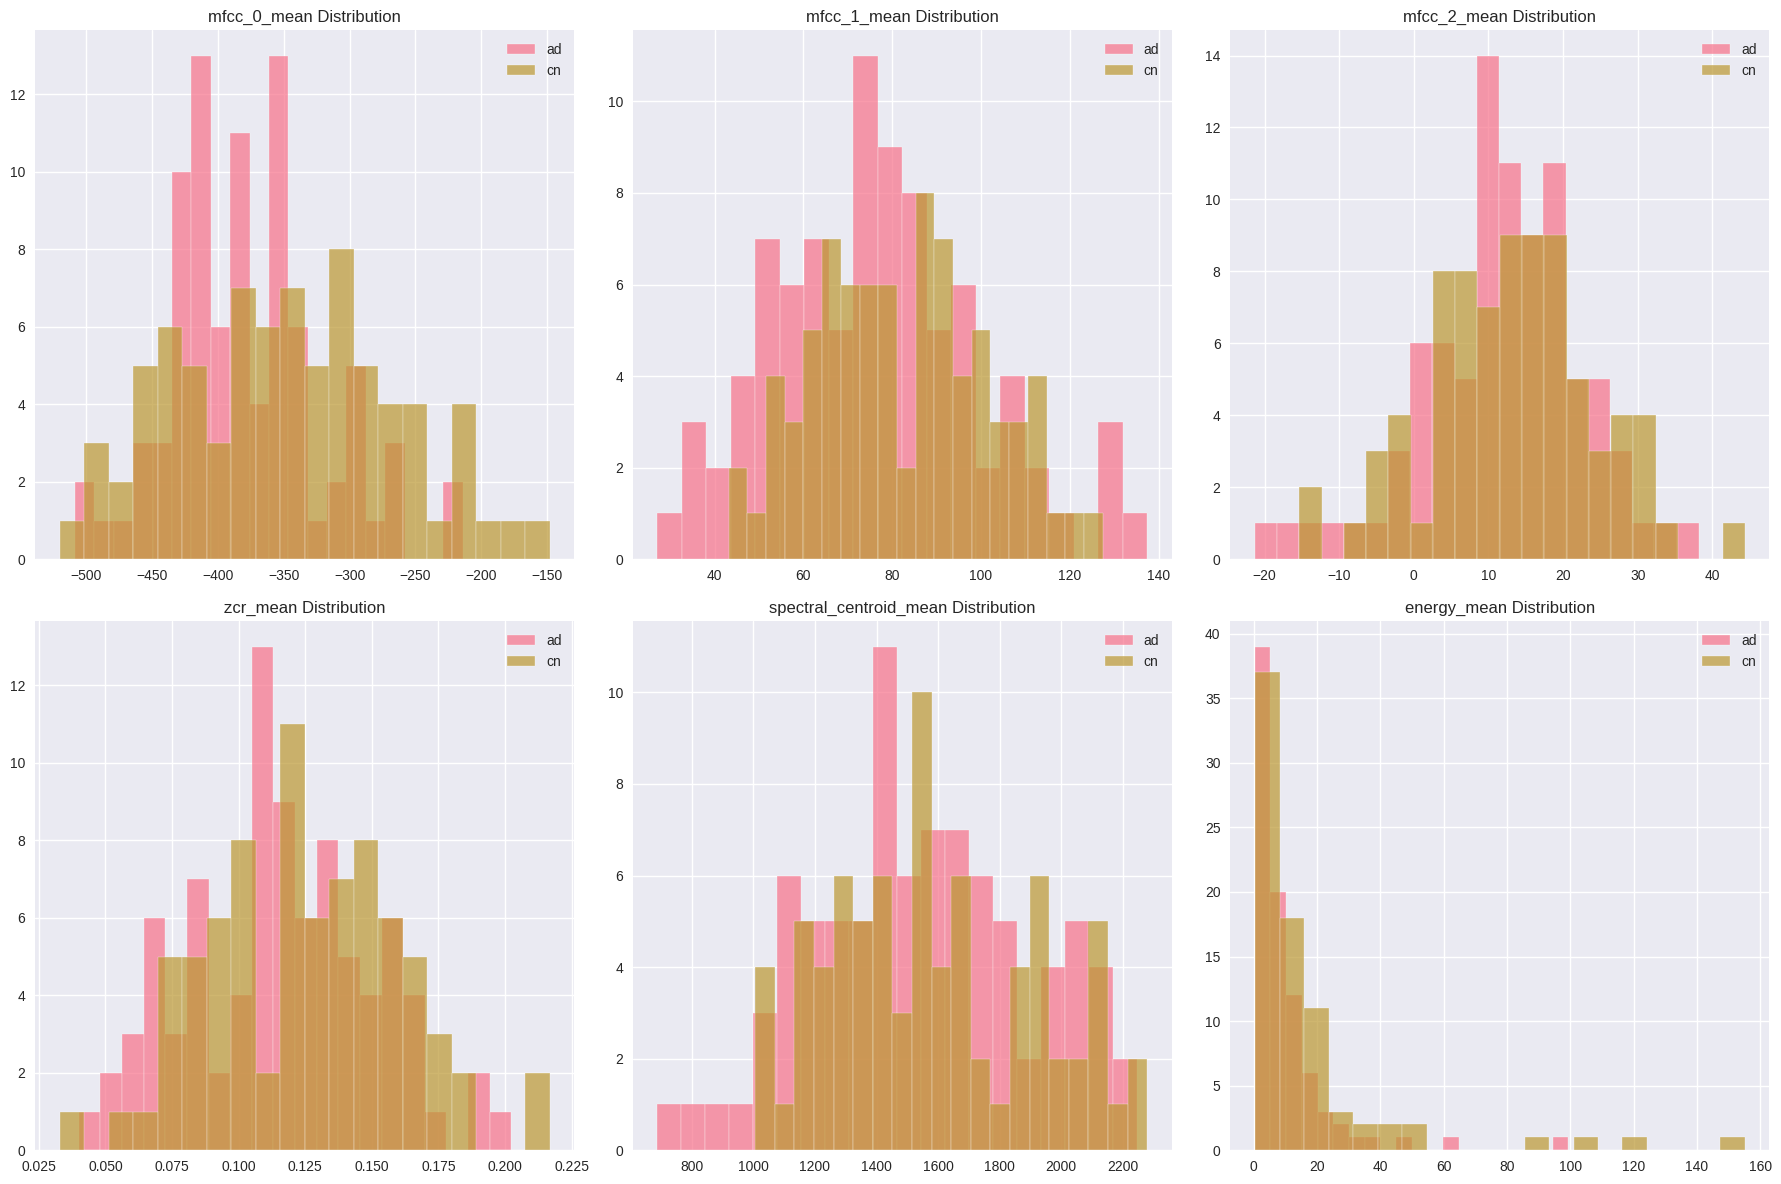

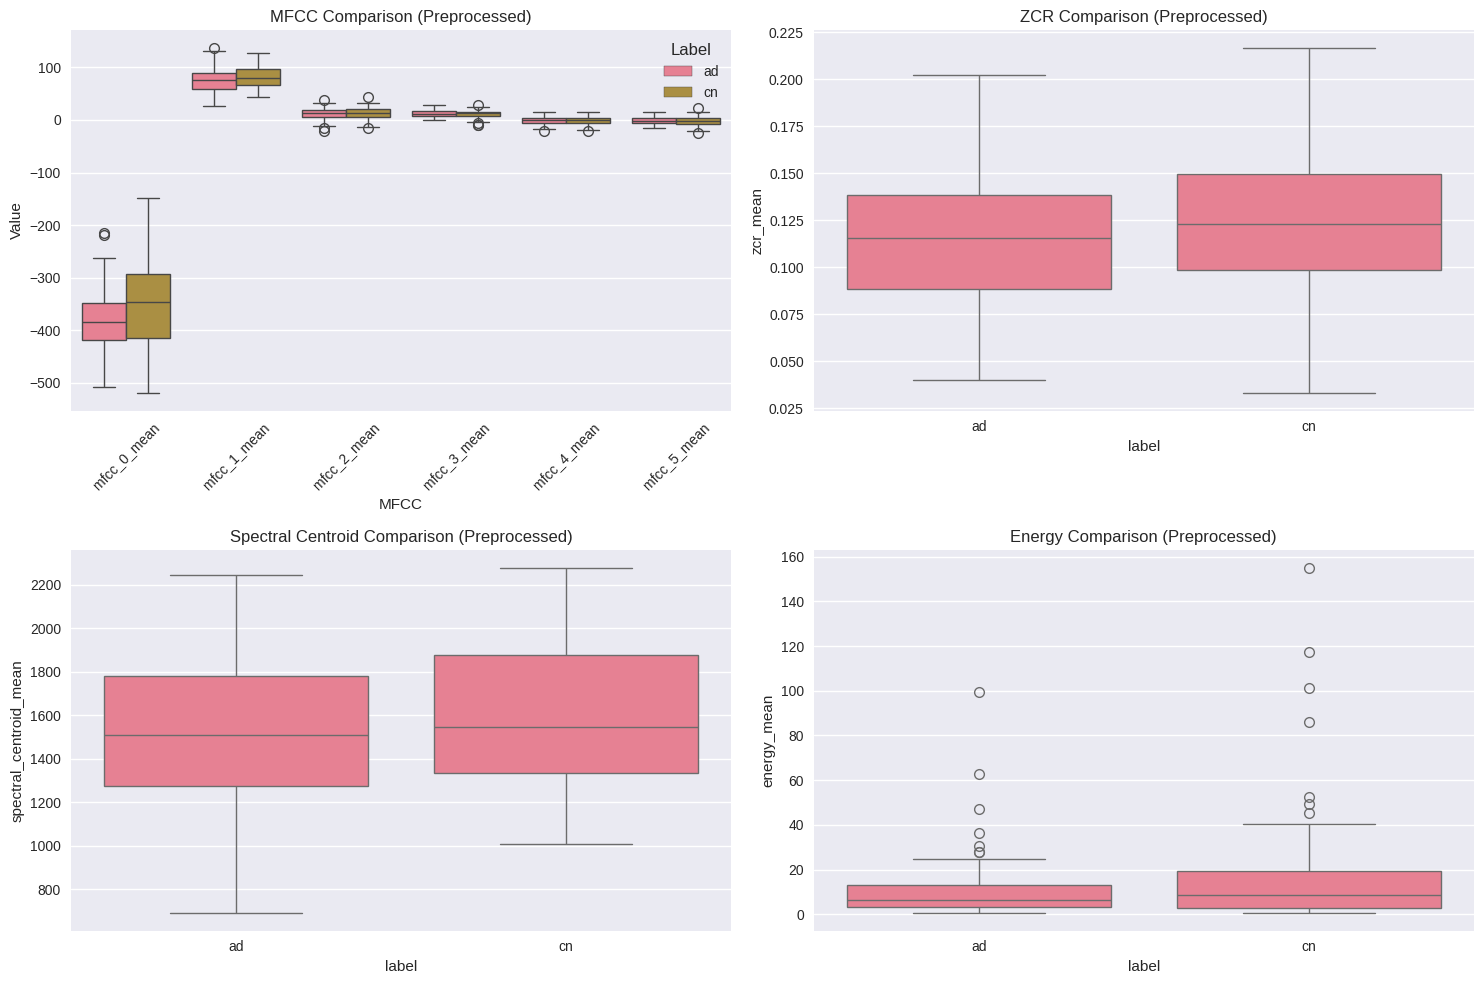

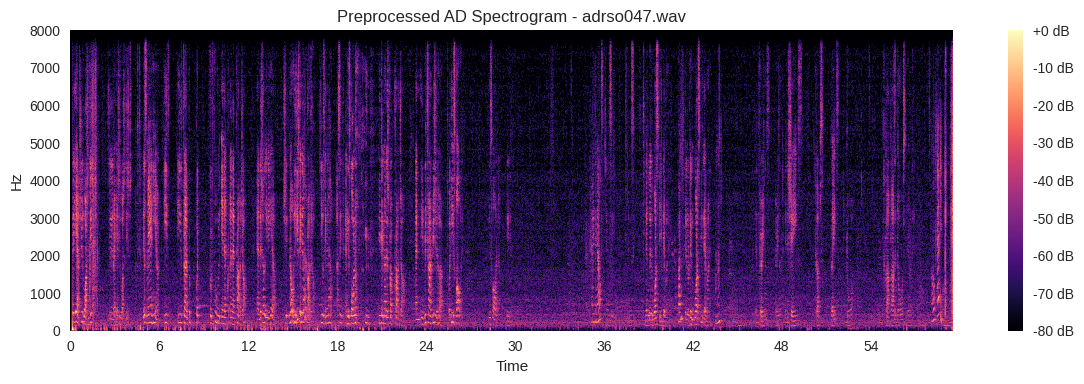

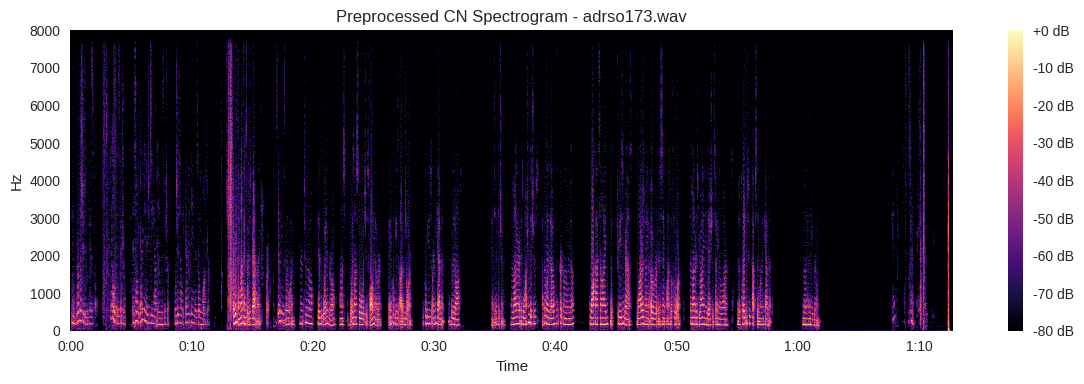

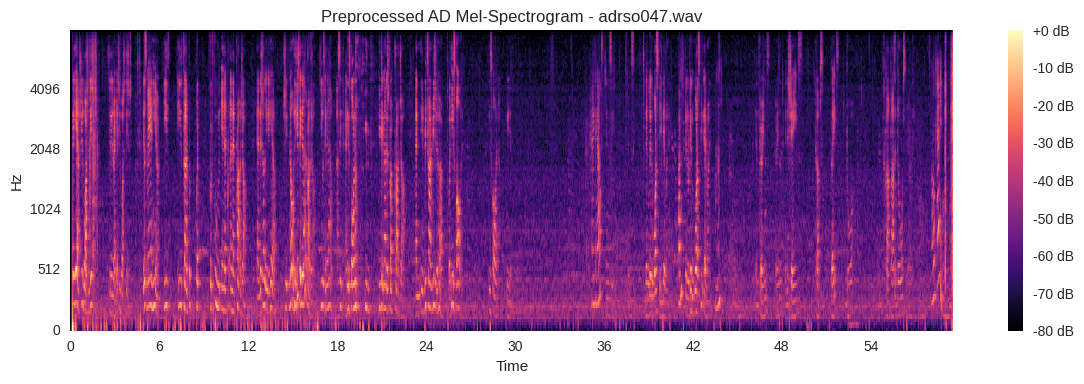

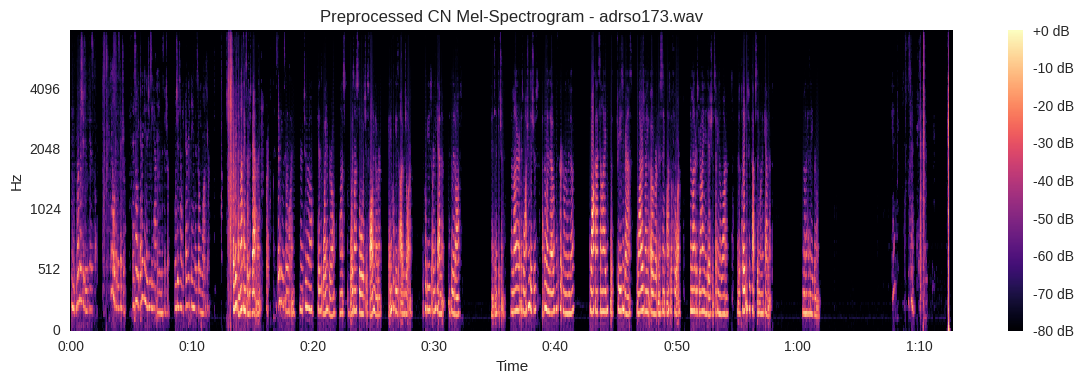

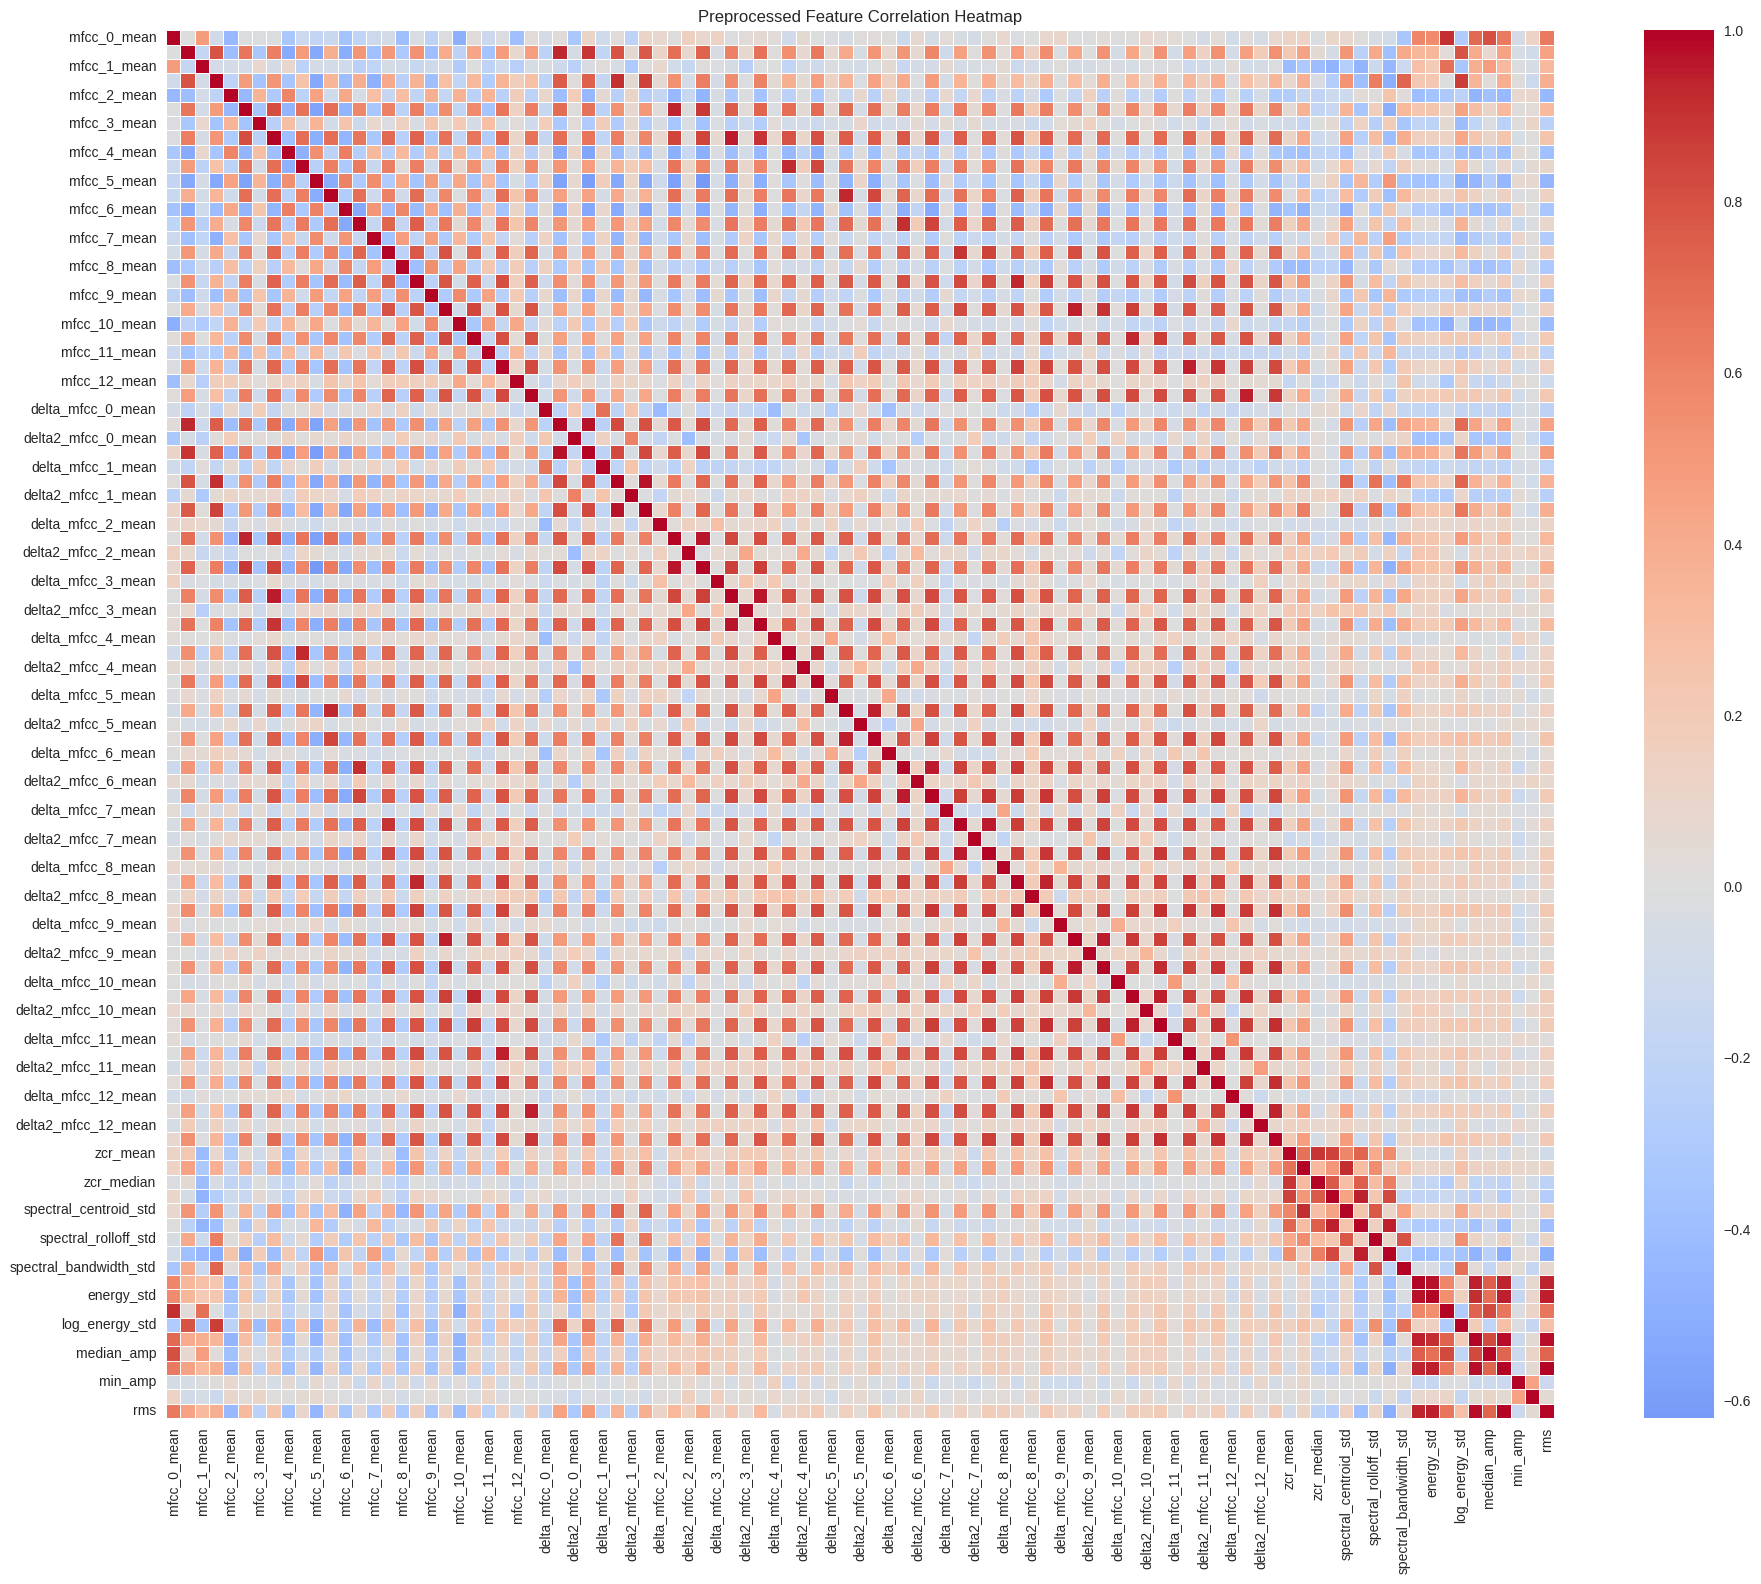

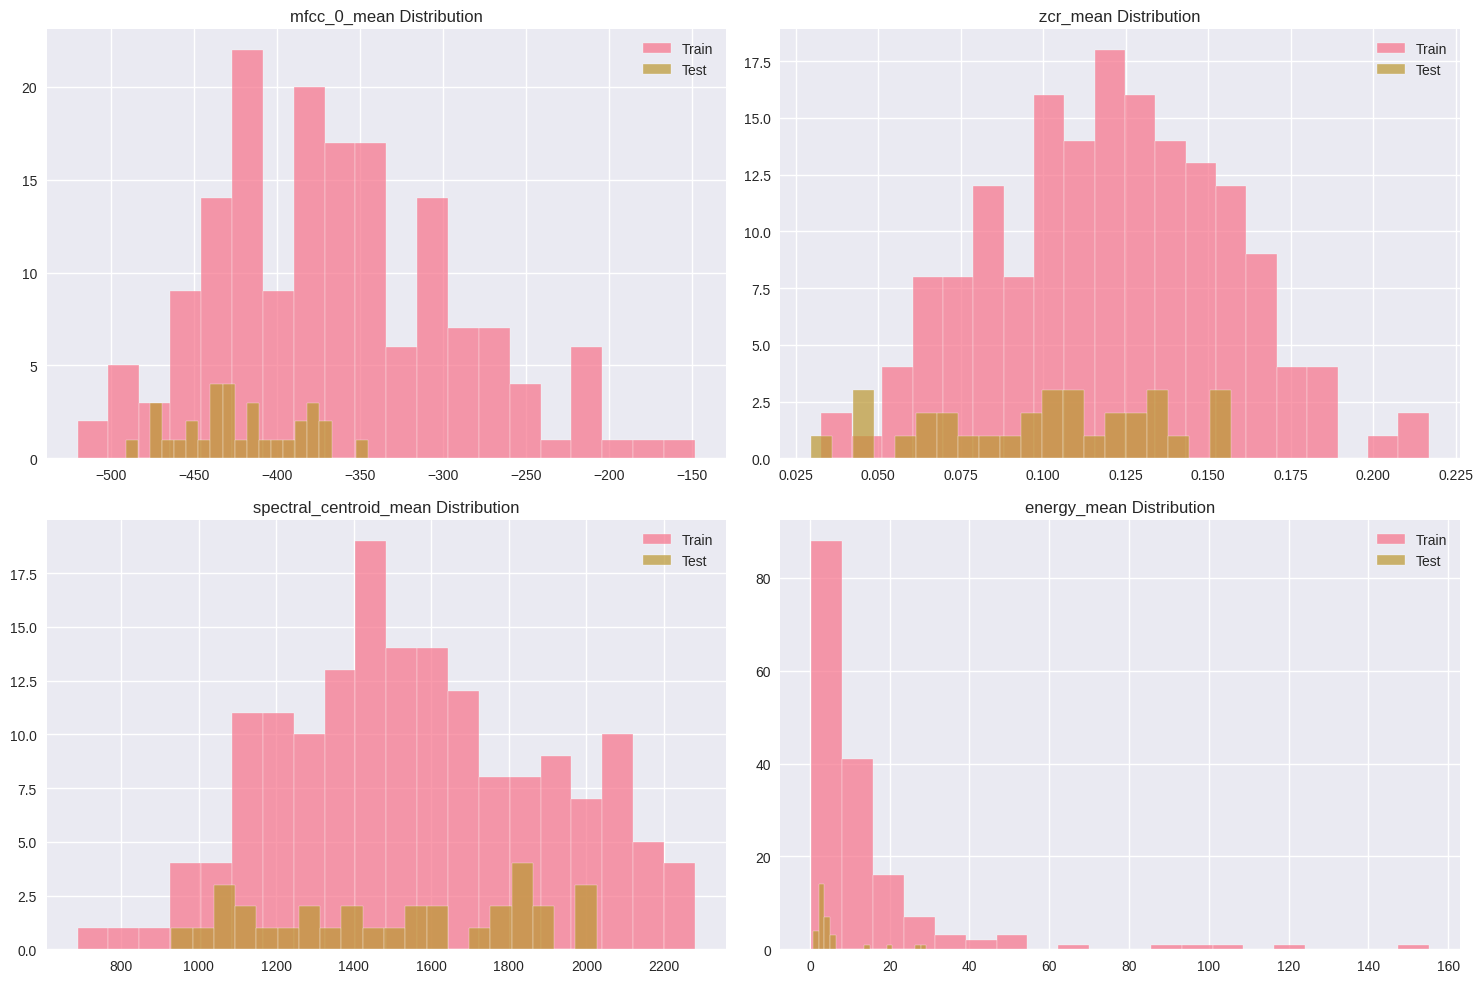


Feature Differences Summary (AD vs CN):
mfcc_0_mean:
  AD: mean=-379.3425, std=57.5560
  CN: mean=-348.0944, std=84.6188
  t-statistic: -2.8038, p-value: 0.0057

zcr_mean:
  AD: mean=0.1157, std=0.0349
  CN: mean=0.1255, std=0.0356
  t-statistic: -1.8077, p-value: 0.0725

spectral_centroid_mean:
  AD: mean=1539.9312, std=350.3183
  CN: mean=1588.6566, std=334.6373
  t-statistic: -0.9142, p-value: 0.3620

energy_mean:
  AD: mean=10.6113, std=14.0715
  CN: mean=16.7954, std=26.2554
  t-statistic: -1.9152, p-value: 0.0572

Starting full preprocessing...
1. Extracting modeling features...
2. Applying noise reduction...
3. Segmenting audio with CSV data...
4. Augmenting audio data...
5. Extracting features from augmented data...


In [ ]:
# ================================
# 3. LIGHT PREPROCESSING
# ================================

def resample_audio(audio_data, target_sr=16000):
    """Resample audio to target sample rate."""
    resampled_data = []

    for item in audio_data:
        if item['sample_rate'] != target_sr:
            y_resampled = librosa.resample(item['audio'],
                                         orig_sr=item['sample_rate'],
                                         target_sr=target_sr)
        else:
            y_resampled = item['audio']

        resampled_item = item.copy()
        resampled_item['audio'] = y_resampled
        resampled_item['sample_rate'] = target_sr
        resampled_item['duration'] = len(y_resampled) / target_sr
        resampled_data.append(resampled_item)

    return resampled_data

def convert_to_mono(audio_data):
    """Convert audio to mono if stereo."""
    mono_data = []

    for item in audio_data:
        y = item['audio']
        if len(y.shape) > 1:
            y_mono = librosa.to_mono(y)
        else:
            y_mono = y

        mono_item = item.copy()
        mono_item['audio'] = y_mono
        mono_data.append(mono_item)

    return mono_data

def normalize_amplitude(audio_data):
    """Normalize amplitude to [-1, 1]."""
    normalized_data = []

    for item in audio_data:
        y = item['audio']
        if np.max(np.abs(y)) > 0:
            y_normalized = y / np.max(np.abs(y))
        else:
            y_normalized = y

        normalized_item = item.copy()
        normalized_item['audio'] = y_normalized
        normalized_data.append(normalized_item)

    return normalized_data

def remove_corrupted_files(audio_data, min_duration=0.5, max_duration=600):
    """Remove corrupted or empty audio files."""
    clean_data = []
    removed_files = []

    for item in audio_data:
        y = item['audio']
        duration = item['duration']

        # Check for corruption indicators
        if (len(y) == 0 or
            duration < min_duration or
            duration > max_duration or
            np.all(y == 0) or
            np.any(np.isnan(y)) or
            np.any(np.isinf(y))):
            removed_files.append(item['filename'])
        else:
            clean_data.append(item)

    print(f"Removed {len(removed_files)} corrupted files: {removed_files}")
    return clean_data

def trim_silence(audio_data, threshold_percentile=30):
    """Trim silence from beginning and end of audio."""
    trimmed_data = []

    for item in audio_data:
        y = item['audio']

        # Calculate dynamic threshold based on signal characteristics
        threshold = np.percentile(np.abs(y), threshold_percentile)

        # Find non-silent regions
        non_silent = np.abs(y) > threshold

        if np.any(non_silent):
            # Find first and last non-silent samples
            first_sample = np.argmax(non_silent)
            last_sample = len(non_silent) - 1 - np.argmax(non_silent[::-1])

            # Trim with small padding
            padding = int(0.1 * item['sample_rate'])  # 0.1 second padding
            start = max(0, first_sample - padding)
            end = min(len(y), last_sample + padding)

            y_trimmed = y[start:end]
        else:
            y_trimmed = y

        trimmed_item = item.copy()
        trimmed_item['audio'] = y_trimmed
        trimmed_item['duration'] = len(y_trimmed) / item['sample_rate']
        trimmed_data.append(trimmed_item)

    return trimmed_data

def align_with_segmentation(audio_data, segmentation_data):
    """Align audio with segmentation data from CSV files."""
    aligned_data = []

    for item in audio_data:
        filename = item['filename']

        if filename in segmentation_data:
            seg_df = segmentation_data[filename]

            # Add segmentation info to audio item
            aligned_item = item.copy()
            aligned_item['segmentation'] = seg_df
            aligned_item['has_segmentation'] = True

            # Calculate speech segments ratio
            if not seg_df.empty and 'start' in seg_df.columns and 'end' in seg_df.columns:
                total_speech_time = np.sum(seg_df['end'] - seg_df['start'])
                speech_ratio = total_speech_time / item['duration']
                aligned_item['speech_ratio'] = speech_ratio
            else:
                aligned_item['speech_ratio'] = 1.0

            aligned_data.append(aligned_item)
        else:
            # No segmentation data available
            no_seg_item = item.copy()
            no_seg_item['segmentation'] = None
            no_seg_item['has_segmentation'] = False
            no_seg_item['speech_ratio'] = 1.0
            aligned_data.append(no_seg_item)

    return aligned_data

print("Starting light preprocessing...")

# Apply preprocessing steps
print("1. Resampling audio to 16 kHz...")
all_audio_data = resample_audio(all_audio_data, target_sr=16000)

print("2. Converting to mono...")
all_audio_data = convert_to_mono(all_audio_data)

print("3. Normalizing amplitude...")
all_audio_data = normalize_amplitude(all_audio_data)

print("4. Removing corrupted files...")
all_audio_data = remove_corrupted_files(all_audio_data)

print("5. Trimming silence...")
all_audio_data = trim_silence(all_audio_data)

print("6. Aligning with segmentation data...")
# Combine all segmentation data
all_segmentation_data = {**train_ad_seg, **train_cn_seg, **test_seg}
all_audio_data = align_with_segmentation(all_audio_data, all_segmentation_data)

print(f"Light preprocessing complete. {len(all_audio_data)} files processed.")

# Update metadata after preprocessing
preprocessed_metadata = create_metadata_dataframe(all_audio_data)
print(f"Preprocessed dataset shape: {preprocessed_metadata.shape}")
print(f"Average duration after preprocessing: {preprocessed_metadata['duration'].mean():.2f} seconds")

# ================================
# 4. DEEPER EDA
# ================================

print("Starting deeper EDA on preprocessed data...")

def recompute_all_features(audio_data):
    """Recompute all features on preprocessed audio."""
    print("Recomputing MFCCs...")
    mfcc_features = extract_mfcc_features(audio_data)

    print("Recomputing delta features...")
    delta_features = extract_delta_features(audio_data)

    print("Recomputing ZCR...")
    zcr_features = compute_zero_crossing_rate(audio_data)

    print("Recomputing spectral features...")
    spectral_features = compute_spectral_features(audio_data)

    print("Recomputing energy features...")
    energy_features = compute_energy_features(audio_data)

    print("Recomputing amplitude statistics...")
    amp_features = compute_amplitude_statistics(audio_data)

    # Combine all features
    combined_features = pd.merge(mfcc_features, delta_features, on=['filename', 'label'])
    combined_features = pd.merge(combined_features, zcr_features, on=['filename', 'label'])
    combined_features = pd.merge(combined_features, spectral_features, on=['filename', 'label'])
    combined_features = pd.merge(combined_features, energy_features, on=['filename', 'label'])
    combined_features = pd.merge(combined_features, amp_features, on=['filename', 'label'])

    return combined_features

# Recompute features on preprocessed data
preprocessed_features = recompute_all_features(all_audio_data)
print(f"Preprocessed features shape: {preprocessed_features.shape}")

def plot_updated_feature_distributions():
    """Plot updated feature distributions for ad vs cn."""
    train_data = preprocessed_features[preprocessed_features['label'].isin(['ad', 'cn'])]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # MFCC distributions
    mfcc_cols = [col for col in train_data.columns if 'mfcc_' in col and '_mean' in col][:3]
    for i, col in enumerate(mfcc_cols):
        for label in ['ad', 'cn']:
            data = train_data[train_data['label'] == label][col]
            axes[0, i].hist(data, alpha=0.7, label=label, bins=20)
        axes[0, i].set_title(f'{col} Distribution')
        axes[0, i].legend()
        axes[0, i].grid(True)

    # Other feature distributions
    other_features = ['zcr_mean', 'spectral_centroid_mean', 'energy_mean']
    for i, col in enumerate(other_features):
        for label in ['ad', 'cn']:
            data = train_data[train_data['label'] == label][col]
            axes[1, i].hist(data, alpha=0.7, label=label, bins=20)
        axes[1, i].set_title(f'{col} Distribution')
        axes[1, i].legend()
        axes[1, i].grid(True)

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/preprocessed_feature_distributions.png', dpi=150)
    plt.show()

def create_preprocessed_boxplots():
    """Create boxplots for preprocessed features."""
    train_data = preprocessed_features[preprocessed_features['label'].isin(['ad', 'cn'])]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # MFCC boxplots
    mfcc_cols = [col for col in train_data.columns if 'mfcc_' in col and '_mean' in col][:6]
    mfcc_data = []
    for col in mfcc_cols:
        for label in ['ad', 'cn']:
            values = train_data[train_data['label'] == label][col]
            for val in values:
                mfcc_data.append({'MFCC': col, 'Value': val, 'Label': label})

    mfcc_df = pd.DataFrame(mfcc_data)
    sns.boxplot(data=mfcc_df, x='MFCC', y='Value', hue='Label', ax=axes[0,0])
    axes[0,0].set_title('MFCC Comparison (Preprocessed)')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

    # ZCR boxplot
    sns.boxplot(data=train_data, x='label', y='zcr_mean', ax=axes[0,1])
    axes[0,1].set_title('ZCR Comparison (Preprocessed)')

    # Spectral centroid boxplot
    sns.boxplot(data=train_data, x='label', y='spectral_centroid_mean', ax=axes[1,0])
    axes[1,0].set_title('Spectral Centroid Comparison (Preprocessed)')

    # Energy boxplot
    sns.boxplot(data=train_data, x='label', y='energy_mean', ax=axes[1,1])
    axes[1,1].set_title('Energy Comparison (Preprocessed)')

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/preprocessed_boxplots.png', dpi=150)
    plt.show()

def plot_updated_spectrograms():
    """Plot updated spectrograms and Mel-spectrograms."""
    ad_data = [item for item in all_audio_data if item['label'] == 'ad']
    cn_data = [item for item in all_audio_data if item['label'] == 'cn']

    plot_spectrograms(ad_data, "Preprocessed AD", max_plots=1)
    plot_spectrograms(cn_data, "Preprocessed CN", max_plots=1)
    plot_mel_spectrograms(ad_data, "Preprocessed AD", max_plots=1)
    plot_mel_spectrograms(cn_data, "Preprocessed CN", max_plots=1)

def create_updated_correlation_heatmap():
    """Create updated correlation heatmap for preprocessed features."""
    numeric_cols = preprocessed_features.select_dtypes(include=[np.number]).columns
    corr_matrix = preprocessed_features[numeric_cols].corr()

    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)
    plt.title('Preprocessed Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('/content/output/visualizations/preprocessed_correlation_heatmap.png', dpi=150)
    plt.show()

def compare_train_test_distributions():
    """Compare feature distributions between train and test sets."""
    train_data = preprocessed_features[preprocessed_features['label'].isin(['ad', 'cn'])]
    test_data = preprocessed_features[preprocessed_features['label'] == 'test']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    features_to_compare = ['mfcc_0_mean', 'zcr_mean', 'spectral_centroid_mean', 'energy_mean']

    for i, feature in enumerate(features_to_compare):
        row, col = i // 2, i % 2

        train_values = train_data[feature]
        test_values = test_data[feature]

        axes[row, col].hist(train_values, alpha=0.7, label='Train', bins=20)
        axes[row, col].hist(test_values, alpha=0.7, label='Test', bins=20)
        axes[row, col].set_title(f'{feature} Distribution')
        axes[row, col].legend()
        axes[row, col].grid(True)

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/train_test_comparison.png', dpi=150)
    plt.show()

def check_segmentation_consistency():
    """Check segmentation data consistency with audio."""
    consistency_report = []

    for item in all_audio_data:
        if item['has_segmentation']:
            seg_df = item['segmentation']
            audio_duration = item['duration']

            if not seg_df.empty and 'start' in seg_df.columns and 'end' in seg_df.columns:
                max_seg_time = seg_df['end'].max()
                min_seg_time = seg_df['start'].min()

                consistency_report.append({
                    'filename': item['filename'],
                    'label': item['label'],
                    'audio_duration': audio_duration,
                    'max_seg_time': max_seg_time,
                    'min_seg_time': min_seg_time,
                    'time_consistent': max_seg_time <= audio_duration and min_seg_time >= 0,
                    'speech_ratio': item['speech_ratio']
                })

    consistency_df = pd.DataFrame(consistency_report)

    if not consistency_df.empty:
        print("Segmentation Consistency Report:")
        print(f"Files with consistent segmentation: {consistency_df['time_consistent'].sum()}")
        print(f"Files with inconsistent segmentation: {(~consistency_df['time_consistent']).sum()}")
        print(f"Average speech ratio: {consistency_df['speech_ratio'].mean():.3f}")

    return consistency_df

# Execute deeper EDA
plot_updated_feature_distributions()
create_preprocessed_boxplots()
plot_updated_spectrograms()
create_updated_correlation_heatmap()
compare_train_test_distributions()
segmentation_consistency = check_segmentation_consistency()

# Summarize differences between ad and cn classes
train_data = preprocessed_features[preprocessed_features['label'].isin(['ad', 'cn'])]
print("\nFeature Differences Summary (AD vs CN):")
print("=" * 50)

for feature in ['mfcc_0_mean', 'zcr_mean', 'spectral_centroid_mean', 'energy_mean']:
    ad_values = train_data[train_data['label'] == 'ad'][feature]
    cn_values = train_data[train_data['label'] == 'cn'][feature]

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(ad_values, cn_values)

    print(f"{feature}:")
    print(f"  AD: mean={ad_values.mean():.4f}, std={ad_values.std():.4f}")
    print(f"  CN: mean={cn_values.mean():.4f}, std={cn_values.std():.4f}")
    print(f"  t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    print()

# ================================
# 5. FULL PREPROCESSING
# ================================

print("Starting full preprocessing...")

def extract_modeling_features(audio_data):
    """Extract comprehensive features for modeling."""
    modeling_features = []

    for item in audio_data:
        y = item['audio']
        sr = item['sample_rate']

        # MFCCs (13 coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # Delta and delta-delta MFCCs
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

        # ZCR
        zcr = librosa.feature.zero_crossing_rate(y)[0]

        # Energy features
        frame_length = 2048
        hop_length = 512
        frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
        energy = np.sum(frames**2, axis=0)
        log_energy = np.log(energy + 1e-8)

        # Compile all features
        features = {}
        features['filename'] = item['filename']
        features['label'] = item['label']

        # MFCC statistics
        for i in range(13):
            features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i}_std'] = np.std(mfccs[i])
            features[f'delta_mfcc_{i}_mean'] = np.mean(delta_mfccs[i])
            features[f'delta_mfcc_{i}_std'] = np.std(delta_mfccs[i])
            features[f'delta2_mfcc_{i}_mean'] = np.mean(delta2_mfccs[i])
            features[f'delta2_mfcc_{i}_std'] = np.std(delta2_mfccs[i])

        # Spectral feature statistics
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)

        # ZCR statistics
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)

        # Energy statistics
        features['energy_mean'] = np.mean(energy)
        features['energy_std'] = np.std(energy)
        features['log_energy_mean'] = np.mean(log_energy)
        features['log_energy_std'] = np.std(log_energy)

        modeling_features.append(features)

    return pd.DataFrame(modeling_features)

def apply_noise_reduction(audio_data, snr_threshold=10):
    """Apply noise reduction based on SNR."""
    denoised_data = []

    for item in audio_data:
        y = item['audio']

        # Simple spectral subtraction for noise reduction
        # Compute short-time FFT
        D = librosa.stft(y)
        magnitude = np.abs(D)
        phase = np.angle(D)

        # Estimate noise from quietest frames
        noise_frame_threshold = np.percentile(np.mean(magnitude, axis=0), 10)
        noise_frames = np.mean(magnitude, axis=0) < noise_frame_threshold

        if np.any(noise_frames):
            noise_spectrum = np.mean(magnitude[:, noise_frames], axis=1, keepdims=True)

            # Spectral subtraction
            alpha = 2.0  # Over-subtraction factor
            denoised_magnitude = magnitude - alpha * noise_spectrum
            denoised_magnitude = np.maximum(denoised_magnitude, 0.1 * magnitude)

            # Reconstruct signal
            denoised_D = denoised_magnitude * np.exp(1j * phase)
            y_denoised = librosa.istft(denoised_D)
        else:
            y_denoised = y

        denoised_item = item.copy()
        denoised_item['audio'] = y_denoised
        denoised_data.append(denoised_item)

    return denoised_data

def segment_audio_with_csv(audio_data):
    """Segment audio using CSV files."""
    segmented_data = []

    for item in audio_data:
        if item['has_segmentation'] and item['segmentation'] is not None:
            seg_df = item['segmentation']
            y = item['audio']
            sr = item['sample_rate']

            if not seg_df.empty and 'start' in seg_df.columns and 'end' in seg_df.columns:
                # Extract speech segments
                speech_segments = []
                for _, row in seg_df.iterrows():
                    start_sample = int(row['start'] * sr)
                    end_sample = int(row['end'] * sr)

                    if start_sample < len(y) and end_sample <= len(y):
                        segment = y[start_sample:end_sample]
                        if len(segment) > 0:
                            speech_segments.append(segment)

                if speech_segments:
                    # Concatenate speech segments
                    y_segmented = np.concatenate(speech_segments)
                else:
                    y_segmented = y
            else:
                y_segmented = y
        else:
            y_segmented = item['audio']

        segmented_item = item.copy()
        segmented_item['audio'] = y_segmented
        segmented_item['duration'] = len(y_segmented) / item['sample_rate']
        segmented_data.append(segmented_item)

    return segmented_data

def augment_audio_data(audio_data):
    """Augment audio data with synthetic noise, pitch shifting, and time stretching."""
    augmented_data = []

    for item in audio_data:
        y = item['audio']
        sr = item['sample_rate']

        # Original audio
        augmented_data.append(item)

        # Only augment training data
        if item['label'] in ['ad', 'cn']:
            # Add synthetic noise
            noise_level = 0.005 * np.random.random()
            noise = np.random.normal(0, noise_level, len(y))
            y_noisy = y + noise

            noisy_item = item.copy()
            noisy_item['audio'] = y_noisy
            noisy_item['filename'] = item['filename'].replace('.wav', '_noisy.wav')
            augmented_data.append(noisy_item)

            # Pitch shifting
            for pitch_shift in [-2, 2]:  # semitones
                y_pitched = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_shift)

                pitched_item = item.copy()
                pitched_item['audio'] = y_pitched
                pitched_item['filename'] = item['filename'].replace('.wav', f'_pitch{pitch_shift}.wav')
                augmented_data.append(pitched_item)

            # Time stretching
            for stretch_rate in [0.9, 1.1]:
                y_stretched = librosa.effects.time_stretch(y, rate=stretch_rate)

                stretched_item = item.copy()
                stretched_item['audio'] = y_stretched
                stretched_item['filename'] = item['filename'].replace('.wav', f'_stretch{stretch_rate}.wav')
                stretched_item['duration'] = len(y_stretched) / sr
                augmented_data.append(stretched_item)

    return augmented_data

def handle_class_imbalance(features_df):
    """Handle class imbalance using SMOTE."""
    train_features = features_df[features_df['label'].isin(['ad', 'cn'])]

    # Prepare data for SMOTE
    X = train_features.drop(['filename', 'label'], axis=1)
    y = train_features['label']

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create new DataFrame
    resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    resampled_df['label'] = y_resampled
    resampled_df['filename'] = [f'synthetic_{i}.wav' for i in range(len(resampled_df))]

    # Add test data back
    test_features = features_df[features_df['label'] == 'test']
    final_features = pd.concat([resampled_df, test_features], ignore_index=True)

    return final_features

def standardize_features(features_df):
    """Standardize features to zero mean and unit variance."""
    train_features = features_df[features_df['label'].isin(['ad', 'cn'])]
    test_features = features_df[features_df['label'] == 'test']

    # Separate features and labels
    feature_columns = [col for col in features_df.columns if col not in ['filename', 'label']]

    # Fit scaler on training data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_features[feature_columns])

    # Transform test data
    test_scaled = scaler.transform(test_features[feature_columns])

    # Create standardized DataFrames
    train_scaled_df = pd.DataFrame(train_scaled, columns=feature_columns)
    train_scaled_df['filename'] = train_features['filename'].values
    train_scaled_df['label'] = train_features['label'].values

    test_scaled_df = pd.DataFrame(test_scaled, columns=feature_columns)
    test_scaled_df['filename'] = test_features['filename'].values
    test_scaled_df['label'] = test_features['label'].values

    standardized_df = pd.concat([train_scaled_df, test_scaled_df], ignore_index=True)

    return standardized_df, scaler

# Execute full preprocessing
print("1. Extracting modeling features...")
modeling_features = extract_modeling_features(all_audio_data)

print("2. Applying noise reduction...")
denoised_audio = apply_noise_reduction(all_audio_data)

print("3. Segmenting audio with CSV data...")
segmented_audio = segment_audio_with_csv(denoised_audio)

print("4. Augmenting audio data...")
augmented_audio = augment_audio_data(segmented_audio)

print("5. Extracting features from augmented data...")
augmented_features = extract_modeling_features(augmented_audio)

print("6. Handling class imbalance...")
balanced_features = handle_class_imbalance(augmented_features)

print("7. Standardizing features...")
standardized_features, feature_scaler = standardize_features(balanced_features)

print(f"Final preprocessed dataset shape: {standardized_features.shape}")
print(f"Class distribution after balancing:")
print(standardized_features['label'].value_counts())

# Save preprocessed data
standardized_features.to_csv('/content/output/preprocessed/standardized_features.csv', index=False)
print("Preprocessed features saved to /content/output/preprocessed/standardized_features.csv")

In [1]:
# ================================
# 6. POST-PREPROCESSING EDA
# ================================

print("Starting post-preprocessing EDA...")

def plot_final_feature_distributions():
    """Plot distributions of final extracted features."""
    train_data = standardized_features[standardized_features['label'].isin(['ad', 'cn'])]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Select key features for visualization
    key_features = ['mfcc_0_mean', 'mfcc_1_mean', 'zcr_mean',
                   'spectral_centroid_mean', 'energy_mean', 'log_energy_mean']

    for i, feature in enumerate(key_features):
        row, col = i // 3, i % 3

        for label in ['ad', 'cn']:
            data = train_data[train_data['label'] == label][feature]
            axes[row, col].hist(data, alpha=0.7, label=label, bins=30, density=True)

        axes[row, col].set_title(f'{feature} Distribution (Standardized)')
        axes[row, col].set_xlabel('Standardized Value')
        axes[row, col].set_ylabel('Density')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/final_feature_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()

def visualize_augmented_spectrograms():
    """Visualize spectrograms of augmented audio samples."""
    # Find augmented samples
    augmented_samples = {
        'original': [item for item in augmented_audio if '_noisy' not in item['filename'] and
                    '_pitch' not in item['filename'] and '_stretch' not in item['filename'] and
                    item['label'] == 'ad'][:1],
        'noisy': [item for item in augmented_audio if '_noisy' in item['filename']][:1],
        'pitch_shifted': [item for item in augmented_audio if '_pitch' in item['filename']][:1],
        'time_stretched': [item for item in augmented_audio if '_stretch' in item['filename']][:1]
    }

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    for i, (aug_type, samples) in enumerate(augmented_samples.items()):
        if samples:
            row, col = i // 2, i % 2
            sample = samples[0]
            y = sample['audio']
            sr = sample['sample_rate']

            # Compute spectrogram
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

            img = librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sr, ax=axes[row, col])
            axes[row, col].set_title(f'{aug_type.title()} Audio Spectrogram')
            plt.colorbar(img, ax=axes[row, col], format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/augmented_spectrograms.png', dpi=150, bbox_inches='tight')
    plt.show()

def check_feature_consistency():
    """Check feature consistency between train and test sets."""
    train_data = standardized_features[standardized_features['label'].isin(['ad', 'cn'])]
    test_data = standardized_features[standardized_features['label'] == 'test']

    feature_columns = [col for col in standardized_features.columns if col not in ['filename', 'label']]

    consistency_results = []

    for feature in feature_columns:
        train_stats = {
            'mean': train_data[feature].mean(),
            'std': train_data[feature].std(),
            'min': train_data[feature].min(),
            'max': train_data[feature].max()
        }

        test_stats = {
            'mean': test_data[feature].mean(),
            'std': test_data[feature].std(),
            'min': test_data[feature].min(),
            'max': test_data[feature].max()
        }

        # Check if test statistics are within reasonable bounds of train statistics
        mean_diff = abs(test_stats['mean'] - train_stats['mean'])
        std_ratio = test_stats['std'] / train_stats['std'] if train_stats['std'] > 0 else 1

        consistency_results.append({
            'feature': feature,
            'train_mean': train_stats['mean'],
            'test_mean': test_stats['mean'],
            'mean_diff': mean_diff,
            'train_std': train_stats['std'],
            'test_std': test_stats['std'],
            'std_ratio': std_ratio,
            'consistent': mean_diff < 0.5 and 0.5 < std_ratio < 2.0
        })

    consistency_df = pd.DataFrame(consistency_results)

    print("Feature Consistency Check:")
    print(f"Total features: {len(consistency_df)}")
    print(f"Consistent features: {consistency_df['consistent'].sum()}")
    print(f"Inconsistent features: {(~consistency_df['consistent']).sum()}")

    if (~consistency_df['consistent']).sum() > 0:
        print("\nInconsistent features:")
        inconsistent = consistency_df[~consistency_df['consistent']]
        print(inconsistent[['feature', 'mean_diff', 'std_ratio']].head(10))

    return consistency_df

def detect_remaining_anomalies():
    """Detect remaining anomalies in preprocessed features."""
    train_data = standardized_features[standardized_features['label'].isin(['ad', 'cn'])]
    feature_columns = [col for col in train_data.columns if col not in ['filename', 'label']]

    # Use Isolation Forest for anomaly detection
    from sklearn.ensemble import IsolationForest

    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    anomaly_labels = iso_forest.fit_predict(train_data[feature_columns])

    anomaly_count = np.sum(anomaly_labels == -1)
    print(f"Anomaly Detection Results:")
    print(f"Total samples: {len(train_data)}")
    print(f"Detected anomalies: {anomaly_count}")
    print(f"Anomaly percentage: {anomaly_count/len(train_data)*100:.2f}%")

    # Check for extreme values
    extreme_values = {}
    for feature in feature_columns:
        values = train_data[feature]
        q1, q3 = np.percentile(values, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr

        extreme_mask = (values < lower_bound) | (values > upper_bound)
        extreme_count = extreme_mask.sum()

        if extreme_count > 0:
            extreme_values[feature] = {
                'count': extreme_count,
                'percentage': extreme_count/len(values)*100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

    print(f"\nExtreme values found in {len(extreme_values)} features")
    for feature, stats in list(extreme_values.items())[:5]:
        print(f"{feature}: {stats['count']} samples ({stats['percentage']:.2f}%)")

    return anomaly_labels, extreme_values

def verify_segmentation_alignment():
    """Verify segmentation alignment with preprocessed audio."""
    alignment_stats = []

    for item in segmented_audio:
        if item['has_segmentation'] and item['segmentation'] is not None:
            seg_df = item['segmentation']
            audio_duration = item['duration']

            if not seg_df.empty:
                total_seg_duration = np.sum(seg_df['end'] - seg_df['start'])
                coverage = total_seg_duration / audio_duration

                alignment_stats.append({
                    'filename': item['filename'],
                    'label': item['label'],
                    'audio_duration': audio_duration,
                    'total_seg_duration': total_seg_duration,
                    'coverage': coverage,
                    'num_segments': len(seg_df)
                })

    if alignment_stats:
        alignment_df = pd.DataFrame(alignment_stats)

        print("Segmentation Alignment Verification:")
        print(f"Files with segmentation: {len(alignment_df)}")
        print(f"Average coverage: {alignment_df['coverage'].mean():.3f}")
        print(f"Average segments per file: {alignment_df['num_segments'].mean():.1f}")

        # Plot coverage distribution
        plt.figure(figsize=(10, 6))
        plt.hist(alignment_df['coverage'], bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Segmentation Coverage')
        plt.ylabel('Frequency')
        plt.title('Distribution of Segmentation Coverage')
        plt.grid(True, alpha=0.3)
        plt.savefig('/content/output/visualizations/segmentation_coverage.png', dpi=150, bbox_inches='tight')
        plt.show()

        return alignment_df
    else:
        print("No segmentation data found")
        return None

def summarize_feature_statistics():
    """Summarize feature statistics for ad and cn classes."""
    train_data = standardized_features[standardized_features['label'].isin(['ad', 'cn'])]
    feature_columns = [col for col in train_data.columns if col not in ['filename', 'label']]

    summary_stats = []

    for feature in feature_columns:
        for label in ['ad', 'cn']:
            data = train_data[train_data['label'] == label][feature]

            stats = {
                'feature': feature,
                'class': label,
                'count': len(data),
                'mean': data.mean(),
                'std': data.std(),
                'min': data.min(),
                'max': data.max(),
                'q25': data.quantile(0.25),
                'q50': data.quantile(0.50),
                'q75': data.quantile(0.75)
            }
            summary_stats.append(stats)

    summary_df = pd.DataFrame(summary_stats)

    # Save summary statistics
    summary_df.to_csv('/content/output/preprocessed/feature_statistics_summary.csv', index=False)

    print("Feature Statistics Summary:")
    print(f"Total features analyzed: {len(feature_columns)}")
    print("\nSample statistics for key features:")

    key_features = ['mfcc_0_mean', 'mfcc_1_mean', 'zcr_mean', 'spectral_centroid_mean']
    for feature in key_features:
        print(f"\n{feature}:")
        feature_stats = summary_df[summary_df['feature'] == feature]
        for _, row in feature_stats.iterrows():
            print(f"  {row['class']}: mean={row['mean']:.4f}, std={row['std']:.4f}")

    return summary_df

def plot_class_comparison_visuals():
    """Plot comprehensive class comparison visuals."""
    train_data = standardized_features[standardized_features['label'].isin(['ad', 'cn'])]

    # 1. MFCC boxplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # MFCC comparison
    mfcc_features = ['mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean']
    mfcc_data = []
    for feature in mfcc_features:
        for label in ['ad', 'cn']:
            values = train_data[train_data['label'] == label][feature]
            for val in values:
                mfcc_data.append({'MFCC': feature, 'Value': val, 'Class': label})

    mfcc_df = pd.DataFrame(mfcc_data)
    sns.boxplot(data=mfcc_df, x='MFCC', y='Value', hue='Class', ax=axes[0,0])
    axes[0,0].set_title('MFCC Comparison (First 4 Coefficients)')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

    # Spectral features comparison
    spectral_features = ['spectral_centroid_mean', 'spectral_rolloff_mean', 'spectral_bandwidth_mean']
    spectral_data = []
    for feature in spectral_features:
        for label in ['ad', 'cn']:
            values = train_data[train_data['label'] == label][feature]
            for val in values:
                spectral_data.append({'Feature': feature, 'Value': val, 'Class': label})

    spectral_df = pd.DataFrame(spectral_data)
    sns.boxplot(data=spectral_df, x='Feature', y='Value', hue='Class', ax=axes[0,1])
    axes[0,1].set_title('Spectral Features Comparison')
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

    # ZCR and Energy comparison
    sns.boxplot(data=train_data, x='label', y='zcr_mean', ax=axes[1,0])
    axes[1,0].set_title('Zero Crossing Rate Comparison')
    axes[1,0].set_xlabel('Class')

    sns.boxplot(data=train_data, x='label', y='energy_mean', ax=axes[1,1])
    axes[1,1].set_title('Energy Comparison')
    axes[1,1].set_xlabel('Class')

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/class_comparison_boxplots.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 2. Feature correlation heatmap by class
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    feature_subset = ['mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'zcr_mean',
                     'spectral_centroid_mean', 'spectral_rolloff_mean', 'energy_mean']

    for i, label in enumerate(['ad', 'cn']):
        class_data = train_data[train_data['label'] == label][feature_subset]
        corr_matrix = class_data.corr()

        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, ax=axes[i], cbar_kws={'shrink': 0.8})
        axes[i].set_title(f'{label.upper()} Class Feature Correlations')

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/class_correlation_heatmaps.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_pca_visualization():
    """Plot PCA visualization of the feature space."""
    from sklearn.decomposition import PCA

    train_data = standardized_features[standardized_features['label'].isin(['ad', 'cn'])]
    feature_columns = [col for col in train_data.columns if col not in ['filename', 'label']]

    # Apply PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(train_data[feature_columns])

    # Plot PCA results
    plt.figure(figsize=(12, 8))

    for label in ['ad', 'cn']:
        mask = train_data['label'] == label
        plt.scatter(pca_features[mask, 0], pca_features[mask, 1],
                   label=f'{label.upper()} class', alpha=0.6, s=50)

    plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('PCA Visualization of Feature Space')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('/content/output/visualizations/pca_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

    return pca

# Execute post-preprocessing EDA
print("1. Plotting final feature distributions...")
plot_final_feature_distributions()

print("2. Visualizing augmented spectrograms...")
visualize_augmented_spectrograms()

print("3. Checking feature consistency...")
consistency_results = check_feature_consistency()

print("4. Detecting remaining anomalies...")
anomaly_labels, extreme_values = detect_remaining_anomalies()

print("5. Verifying segmentation alignment...")
alignment_results = verify_segmentation_alignment()

print("6. Summarizing feature statistics...")
feature_summary = summarize_feature_statistics()

print("7. Creating class comparison visuals...")
plot_class_comparison_visuals()

print("8. Creating PCA visualization...")
pca_model = plot_pca_visualization()

print("Post-preprocessing EDA completed successfully!")

# Final data quality report
print("\n" + "="*60)
print("FINAL DATA QUALITY REPORT")
print("="*60)

print(f"Final dataset shape: {standardized_features.shape}")
print(f"Number of features: {len([col for col in standardized_features.columns if col not in ['filename', 'label']])}")

class_counts = standardized_features['label'].value_counts()
print(f"\nClass distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} samples")

print(f"\nFeature consistency: {consistency_results['consistent'].sum()}/{len(consistency_results)} features consistent")
print(f"Detected anomalies: {np.sum(anomaly_labels == -1)} samples")
print(f"Features with extreme values: {len(extreme_values)}")

if alignment_results is not None:
    print(f"Average segmentation coverage: {alignment_results['coverage'].mean():.3f}")

print("\nDataset is ready for machine learning modeling!")

Starting post-preprocessing EDA...
1. Plotting final feature distributions...


NameError: name 'standardized_features' is not defined